## The pangenome evolution of Listeria monocytogenes is associated with both abiotic factors and bacterial community composition

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.multitest as smt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from itertools import combinations
from collections import defaultdict
from statannot import add_stat_annotation

In [2]:
# Folder paths
data_path = "/projects/leaph/yingxian/0_datasets/"
data_path_lm = "/projects/leaph/yingxian/0_datasets/lm_lineage/"
out_path_1 = "/projects/leaph/yingxian/lm_lineage_4va/out/fig_1/"
out_path_2 = "/projects/leaph/yingxian/lm_lineage_4va/out/fig_2/"
out_path_3 = "/projects/leaph/yingxian/lm_lineage_4va/out/fig_3/"
out_path_4 = "/projects/leaph/yingxian/lm_lineage_4va/out/fig_4/"
out_path_supp = "/projects/leaph/yingxian/lm_lineage_4va/out/supp_figs/"
out_path_oth = "/projects/leaph/yingxian/lm_lineage_4va/out/others/"

In [3]:
def plot_heatmap_gene(heatmap_df, color, title="", out_path="", file_title="", figsize=(6, 6)):
    """
    Plots a heatmap based on values in 'I', 'II', and 'III' columns.

    Parameters:
    - heatmap_df (DataFrame): The DataFrame containing values for plotting the heatmap.
    - color (str): Color map for the heatmap.
    - title (str): Title of the plot.
    - out_path (str): Output path for saving the plot.
    - file_title (str): File title for saving the plot.
    - figsize (tuple): Size of the figure.
    """

    # Select only the columns 'I', 'II', and 'III' for plotting the heatmap
    heatmap_data = heatmap_df[['I', 'II', 'III']]

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data, cmap=color, annot=False, linewidths=0.5, vmin=0, vmax=1)

    plt.xlabel('Lineage', size=15)
    plt.ylabel('Gene', size=15)
    plt.title(title, size=15)

    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('Proportion')

    # Add this line to fit the plot
    plt.tight_layout()

    # Generate a safe file title
    safe_file_title = file_title.replace("/", "_").replace("\\", "_")

    # Save the figure
    plt.savefig(f"{out_path}/{safe_file_title}.pdf", format="pdf", dpi=300)

    plt.show()


In [4]:
def plot_heatmap_gene_annot(heatmap_df, color, title="", out_path="", file_title="", figsize=(6, 6)):
    """
    Plots a heatmap based on values in 'I', 'II', and 'III' columns and annotates cells with values from
    'LM lineage I', 'LM lineage II', and 'LM lineage III' columns.

    Parameters:
    - heatmap_df (DataFrame): The DataFrame containing values for plotting the heatmap and annotations.
    - color (str): Color map for the heatmap.
    - title (str): Title of the plot.
    - out_path (str): Output path for saving the plot.
    - file_title (str): File title for saving the plot.
    - figsize (tuple): Size of the figure.
    """

    # Ensure required columns are present
    required_columns = ['I', 'II', 'III']
    annotation_columns = [f'LM lineage {col}' for col in required_columns]
    missing_cols = [col for col in required_columns + annotation_columns if col not in heatmap_df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}. Please check the DataFrame columns.")
        return

    # Select only the columns 'I', 'II', and 'III' for plotting the heatmap
    heatmap_data = heatmap_df[required_columns]

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data, cmap=color, annot=False, linewidths=0.5, vmin=0, vmax=1)

    # Iterate through the values and annotate the cells
    for i, row in enumerate(heatmap_data.index):
        for j, col in enumerate(heatmap_data.columns):
            annotation_column = f'LM lineage {col}'
            annotation_value = heatmap_df.at[row, annotation_column]

            # Annotate only if the value is not NaN
            if not pd.isnull(annotation_value):
                ax.text(j + 0.5, i + 0.5, annotation_value,
                        ha='center', va='center', fontsize=10, color='#CB4335')

    plt.xlabel('Lineage', fontsize=12)
    plt.ylabel('Gene', fontsize=12)
    plt.title(title, fontsize=15)

    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('Proportion')

    # Ensure layout fits nicely
    plt.tight_layout()

    # Generate a safe file title
    safe_file_title = file_title.replace("/", "_").replace("\\", "_")

    # Save the figure
    full_path = f"{out_path}{safe_file_title}.pdf"
    plt.savefig(full_path, format="pdf", dpi=300)
    print(f"Plot saved to {full_path}")

    plt.show()

In [5]:
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

In [6]:
# Function for FDR correction
def fdr_sig(p_value):
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key][0])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    sig_fdr = {}
    for c_key in p_value:
        if p_corr[n_p] < 0.05:
            sig_fdr[c_key] = p_corr[n_p]
        n_p = n_p + 1
    return sig_fdr

### Fig. 1 | Genomic variation of Lm lineages

#### Fig. 1a Venn diagram showing the pangenome of Lm

In [7]:
def assign_core_accessory(df, output_path, output_filename):
    """
    Process the input DataFrame, categorize rows based on the presence of '1' and '0', 
    and save the resulting DataFrame to a CSV file.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to be processed.
    output_path (str): The directory path where the CSV file will be saved.
    output_filename (str): The name of the CSV file.
    
    Returns:
    None
    """
    # Convert all values to strings and strip spaces
    df = df.applymap(lambda x: str(x).strip())

    # Remove rows where all cells (excluding the index) contain '0'
    df = df.loc[~(df == '0').all(axis=1)]

    # Categorize rows based on the presence of '1' and '0'
    df.loc[(df == '1').all(axis=1), 'cat'] = 'core'
    df['cat'].fillna('accessory', inplace=True)

    # Export to CSV
    output_file = out_path_oth + output_filename
    df.to_csv(output_file)

In [8]:
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
assign_core_accessory(gen_pre_abs, './', 'overall_pangenome.csv')
overall_pan = pd.read_csv(out_path_oth + "overall_pangenome.csv", index_col=0)

overall_pan_counts = overall_pan['cat'].value_counts()
overall_pan_percent = overall_pan['cat'].value_counts(normalize=True) * 100

print(overall_pan_counts)
print(overall_pan_percent)

cat
accessory    3549
core         2324
Name: count, dtype: int64
cat
accessory    60.429082
core         39.570918
Name: proportion, dtype: float64


In [9]:
# Loading input data
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()

In [10]:
# Defining combination
lm_1_2 = lm_1 + lm_2
lm_1_3 = lm_1 + lm_3
lm_2_3 = lm_2 + lm_3

In [11]:
# Assigning Lm lineages
lm_1_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_1)]
lm_2_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_2)]
lm_3_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_3)]
lm_1_2_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_1_2)]
lm_1_3_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_1_3)]
lm_2_3_pre_abs = gen_pre_abs[gen_pre_abs.index.isin(lm_2_3)]

# Transpose back to y = gene and x = isolate
lm_1_pre_abs = lm_1_pre_abs.transpose()
lm_2_pre_abs = lm_2_pre_abs.transpose()
lm_3_pre_abs = lm_3_pre_abs.transpose()
lm_1_2_pre_abs = lm_1_2_pre_abs.transpose()
lm_1_3_pre_abs = lm_1_3_pre_abs.transpose()
lm_2_3_pre_abs = lm_2_3_pre_abs.transpose()

# Identifying the core (all consist of '1') and accessory genomes (consist of '1' and '0') for Lm
assign_core_accessory(lm_1_pre_abs, './', 'lm_1_pangenome.csv')
assign_core_accessory(lm_2_pre_abs, './', 'lm_2_pangenome.csv')
assign_core_accessory(lm_3_pre_abs, './', 'lm_3_pangenome.csv')
assign_core_accessory(lm_1_2_pre_abs, './', 'lm_1_2_pangenome.csv')
assign_core_accessory(lm_1_3_pre_abs, './', 'lm_2_3_pangenome.csv')
assign_core_accessory(lm_2_3_pre_abs, './', 'lm_1_3_pangenome.csv')

lm_1_pan = pd.read_csv(out_path_oth + "lm_1_pangenome.csv", index_col=0)
lm_2_pan = pd.read_csv(out_path_oth + "lm_2_pangenome.csv", index_col=0)
lm_3_pan = pd.read_csv(out_path_oth + "lm_3_pangenome.csv", index_col=0) 
lm_1_2_pan = pd.read_csv(out_path_oth + "lm_1_2_pangenome.csv", index_col=0)
lm_1_3_pan = pd.read_csv(out_path_oth + "lm_1_3_pangenome.csv", index_col=0)
lm_2_3_pan = pd.read_csv(out_path_oth + "lm_2_3_pangenome.csv", index_col=0)
lm_1_2_3_pan = pd.read_csv(out_path_oth + "overall_pangenome.csv", index_col=0)

In [12]:
# For lineage I
# Initialize an empty dictionary to store the counts
result = {}

# Iterate over species columns (ignoring 'gene' and 'cat')
for species in lm_1_pan.columns[0:-1]:
    core_count = lm_1_pan[lm_1_pan['cat'] == 'core'][species].sum()  # Sum of 1's where cat is core
    accessory_count = lm_1_pan[lm_1_pan['cat'] == 'accessory'][species].sum()  # Sum of 1's where cat is accessory
    result[species] = {'core': core_count, 'accessory': accessory_count}

# Create a new DataFrame from the result dictionary
output_df_1 = pd.DataFrame(result).T
output_df_1['core:accessory_ratio'] = output_df_1['core'] / output_df_1['accessory']
output_df_1['lineage'] = "I"

# For lineage II
# Initialize an empty dictionary to store the counts
result = {}

# Iterate over species columns (ignoring 'gene' and 'cat')
for species in lm_2_pan.columns[0:-1]:
    core_count = lm_2_pan[lm_2_pan['cat'] == 'core'][species].sum()  # Sum of 1's where cat is core
    accessory_count = lm_2_pan[lm_2_pan['cat'] == 'accessory'][species].sum()  # Sum of 1's where cat is accessory
    result[species] = {'core': core_count, 'accessory': accessory_count}

# Create a new DataFrame from the result dictionary
output_df_2 = pd.DataFrame(result).T
output_df_2['core:accessory_ratio'] = output_df_2['core'] / output_df_2['accessory']
output_df_2['lineage'] = "II"

# For lineage III
# Initialize an empty dictionary to store the counts
result = {}

# Iterate over species columns (ignoring 'gene' and 'cat')
for species in lm_3_pan.columns[0:-1]:
    core_count = lm_3_pan[lm_3_pan['cat'] == 'core'][species].sum()  # Sum of 1's where cat is core
    accessory_count = lm_3_pan[lm_3_pan['cat'] == 'accessory'][species].sum()  # Sum of 1's where cat is accessory
    result[species] = {'core': core_count, 'accessory': accessory_count}

# Create a new DataFrame from the result dictionary
output_df_3 = pd.DataFrame(result).T
output_df_3['core:accessory_ratio'] = output_df_3['core'] / output_df_3['accessory']
output_df_3['lineage'] = "III"

In [13]:
# Extract 'cat' columns and rename them
lm_1 = lm_1_pan[['cat']].rename(columns={'cat': 'lm_1'})
lm_2 = lm_2_pan[['cat']].rename(columns={'cat': 'lm_2'})
lm_3 = lm_3_pan[['cat']].rename(columns={'cat': 'lm_3'})
lm_1_2 = lm_1_2_pan[['cat']].rename(columns={'cat': 'lm_1_2'})
lm_1_3 = lm_1_3_pan[['cat']].rename(columns={'cat': 'lm_1_3'})
lm_2_3 = lm_2_3_pan[['cat']].rename(columns={'cat': 'lm_2_3'})
lm_1_2_3 = lm_1_2_3_pan[['cat']].rename(columns={'cat': 'lm_1_2_3'})

# Merge all the 'cat' columns into a new DataFrame based on their index
merged_df = lm_1.merge(lm_2, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(lm_3, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(lm_1_2, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(lm_1_3, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(lm_2_3, left_index=True, right_index=True, how='outer')
merged_df = merged_df.merge(lm_1_2_3, left_index=True, right_index=True, how='outer')

In [14]:
combinations = merged_df.value_counts(subset=['lm_1', 'lm_2', 'lm_3', 'lm_1_2', 'lm_1_3', 'lm_2_3', 'lm_1_2_3'])

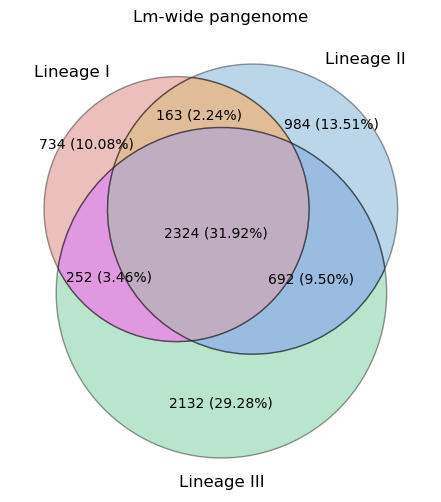

In [15]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Get the counts for each set
core_1 = merged_df[(merged_df['lm_1'] == 'core') & (merged_df['lm_2'] != 'core') & (merged_df['lm_3'] != 'core')].shape[0]
core_2 = merged_df[(merged_df['lm_2'] == 'core') & (merged_df['lm_1'] != 'core') & (merged_df['lm_3'] != 'core')].shape[0]
core_3 = merged_df[(merged_df['lm_3'] == 'core') & (merged_df['lm_1'] != 'core') & (merged_df['lm_2'] != 'core')].shape[0]
core_1_2 = merged_df[(merged_df['lm_1'] == 'core') & (merged_df['lm_2'] == 'core') & (merged_df['lm_3'] != 'core')].shape[0]
core_1_3 = merged_df[(merged_df['lm_1'] == 'core') & (merged_df['lm_3'] == 'core') & (merged_df['lm_2'] != 'core')].shape[0]
core_2_3 = merged_df[(merged_df['lm_2'] == 'core') & (merged_df['lm_3'] == 'core') & (merged_df['lm_1'] != 'core')].shape[0]
core_1_2_3 = merged_df[(merged_df['lm_1'] == 'core') & (merged_df['lm_2'] == 'core') & (merged_df['lm_3'] == 'core')].shape[0]

# Now we add accessory gene counts
accessory_1 = merged_df[(merged_df['lm_1'] == 'accessory') & (merged_df['lm_2'] != 'accessory') & (merged_df['lm_3'] != 'accessory')].shape[0]
accessory_2 = merged_df[(merged_df['lm_2'] == 'accessory') & (merged_df['lm_1'] != 'accessory') & (merged_df['lm_3'] != 'accessory')].shape[0]
accessory_3 = merged_df[(merged_df['lm_3'] == 'accessory') & (merged_df['lm_1'] != 'accessory') & (merged_df['lm_2'] != 'accessory')].shape[0]
accessory_1_2 = merged_df[(merged_df['lm_1'] == 'accessory') & (merged_df['lm_2'] == 'accessory') & (merged_df['lm_3'] != 'accessory')].shape[0]
accessory_1_3 = merged_df[(merged_df['lm_1'] == 'accessory') & (merged_df['lm_3'] == 'accessory') & (merged_df['lm_2'] != 'accessory')].shape[0]
accessory_2_3 = merged_df[(merged_df['lm_2'] == 'accessory') & (merged_df['lm_3'] == 'accessory') & (merged_df['lm_1'] != 'accessory')].shape[0]
accessory_1_2_3 = merged_df[(merged_df['lm_1'] == 'accessory') & (merged_df['lm_2'] == 'accessory') & (merged_df['lm_3'] == 'accessory')].shape[0]

# Prepare the Venn diagram
plt.figure(figsize=(6,6))

venn = venn3(subsets = (
    core_1 + accessory_1 + accessory_1_2_3,        # Unique to lm_1
    core_2 + accessory_2 + accessory_1_2_3,        # Unique to lm_2
    core_1_2 + accessory_1_2,                      # Shared between lm_1 and lm_2
    core_3 + accessory_3 + accessory_1_2_3,        # Unique to lm_3
    core_1_3 + accessory_1_3,                      # Shared between lm_1 and lm_3
    core_2_3 + accessory_2_3,                      # Shared between lm_2 and lm_3
    core_1_2_3                                     # Shared between all three
), set_labels=('Lineage I', 'Lineage II', 'Lineage III'))

# Set colors for the venn diagram
venn.get_patch_by_id('100').set_color('#CD6155')  # lm_1 unique
venn.get_patch_by_id('010').set_color('#5499C7')  # lm_2 unique
venn.get_patch_by_id('001').set_color('#52BE80')  # lm_3 unique

# Add edge color to each patch
for patch in venn.patches:
    if patch is not None:
        patch.set_edgecolor('black')

# Calculate total number of genes (assuming merged_df has a unique index for each gene)
total_genes = core_1 + accessory_1 + accessory_1_2_3 + core_2 + accessory_2 + accessory_1_2_3 + core_1_2 + accessory_1_2 + core_3 + accessory_3 + accessory_1_2_3 + core_1_3 + accessory_1_3 + core_2_3 + accessory_2_3 + core_1_2_3

# Function to add percentage labels
def add_percentage_label(venn, id, count):
    if venn.get_label_by_id(id) is not None:  # Check if the section exists in the Venn diagram
        percentage = (count / total_genes) * 100
        venn.get_label_by_id(id).set_text(f"{count} ({percentage:.2f}%)")

# Adding percentage labels for each section
add_percentage_label(venn, '100', core_1 + accessory_1 + accessory_1_2_3)      # Unique to lm_1
add_percentage_label(venn, '010', core_2 + accessory_2 + accessory_1_2_3)      # Unique to lm_2
add_percentage_label(venn, '001', core_3 + accessory_3 + accessory_1_2_3)      # Unique to lm_3
add_percentage_label(venn, '110', core_1_2 + accessory_1_2)                    # Shared between lm_1 and lm_2
add_percentage_label(venn, '101', core_1_3 + accessory_1_3)                    # Shared between lm_1 and lm_3
add_percentage_label(venn, '011', core_2_3 + accessory_2_3)                    # Shared between lm_2 and lm_3
add_percentage_label(venn, '111', core_1_2_3)                                  # Shared among all three

plt.title('Lm-wide pangenome')
plt.savefig(out_path_1 + 'fig_1a_venn.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Supplementary Fig. 1a Comparing observed and predicted pangenome size of Lm lineages

In [16]:
# Reading the dataframe
lm_1_pan = pd.read_csv(out_path_oth + "lm_1_pangenome.csv", index_col=0)
lm_2_pan = pd.read_csv(out_path_oth + "lm_2_pangenome.csv", index_col=0)
lm_3_pan = pd.read_csv(out_path_oth + "lm_3_pangenome.csv", index_col=0)

# Calculating the expected pangenome size using power law function (Extended Data Fig. 7 in ref: https://doi.org/10.1038/s41564-021-00935-7)
# Calculate the predicted pangenome size for 100 genomes - see if the trend is the consistent with the observed ones
pan_exp_lm_1 = 2723 * (100 ** 0.093)
pan_exp_lm_2 = 2618 * (100 ** 0.122)
pan_exp_lm_3 = 2490 * (100 ** 0.159)

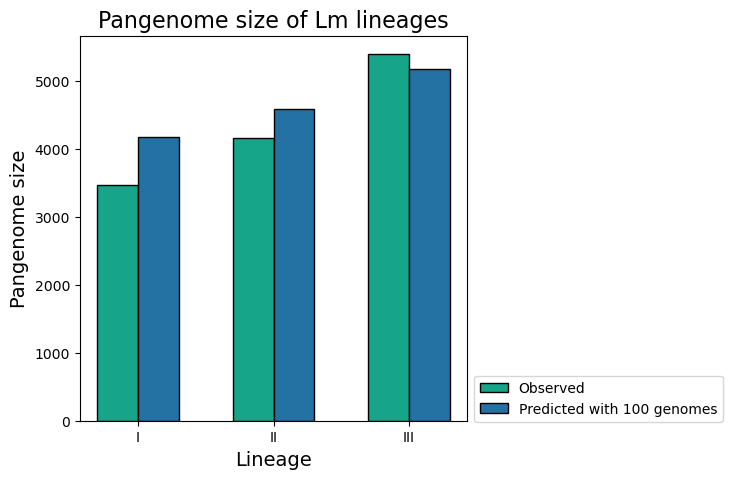

In [17]:
# Plotting the barchart
# Group labels
lineages = ['I', 'II', 'III']

# Values for len(lm_1_pan) and pan_exp_lm_1 for each lineage
pan_obs = [len(lm_1_pan), len(lm_2_pan), len(lm_3_pan)]
pan_exp = [pan_exp_lm_1, pan_exp_lm_2, pan_exp_lm_3]

# Plotting
plt.figure(figsize=(5, 5))

# Bar width
bar_width = 0.3

# Bar positions
r1 = range(len(lineages))
r2 = [x + bar_width for x in r1]

# Plot bars
plt.bar(r1, pan_obs, color='#17A589', width=bar_width, edgecolor='#000000', label='Observed')
plt.bar(r2, pan_exp, color='#2471A3', width=bar_width, edgecolor='#000000', label='Predicted with 100 genomes')

# Add xticks on the middle of the group bars
plt.xlabel('Lineage', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(lineages))], lineages)

# Add y label
plt.ylabel('Pangenome size', fontsize=14)

# Add legend
plt.legend(title='Pangenome size')
plt.legend(bbox_to_anchor=(1.00, 0.135))

# Show plot
plt.title('Pangenome size of Lm lineages', fontsize=16)
plt.savefig(out_path_1 + 'supp_fig_1a_compare_pangenome.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 1b Functional enrichment analysis of COG categories for lineage-associated genes

In [18]:
# Load input data
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

lm_isolate = isolate[isolate["Species"] == "L. monocytogenes"]
lm_isolate = lm_isolate.set_index('Isolate ID')

lm_1 = list(lm_isolate[lm_isolate["Phylogroup"] == "I"].index)
lm_2 = list(lm_isolate[lm_isolate["Phylogroup"] == "II"].index)
lm_3 = list(lm_isolate[lm_isolate["Phylogroup"] == "III"].index)
lm_all = lm_isolate.index.tolist()

gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)

gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

In [19]:
# Function to split rows

def split_rows(df, column):
    # Split the 'COG Functional Category' column and create a new DataFrame with exploded rows
    df_expanded = df[column].apply(lambda x: pd.Series(list(x))).stack().reset_index(level=1, drop=True).to_frame(column)
    
    # Merge the expanded 'COG Functional Category' with the rest of the DataFrame
    df_expanded = df_expanded.join(df.drop(columns=[column]), how='left')
    
    return df_expanded

In [20]:
# Identifying the genes significantly different among Lm lineages

import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table
from collections import defaultdict
import statsmodels.stats.multitest as smt

# Create a dictionary to store p-values
pval = defaultdict(list)

# Function to perform Fisher's Exact Test for a 2x3 table
def fisher_exact_2x3(table):
    # Using statsmodels' Table class for Fisher's Exact Test
    tbl = Table(table)
    result = tbl.test_nominal_association()
    p_value = result.pvalue
    return p_value

# Perform Fisher's Exact Test for each gene
for gene in gen_pre_abs.index:
    # Create a contingency table for each gene
    group_1 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_1)]
    group_2 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_2)]
    group_3 = gen_pre_abs.loc[gene, gen_pre_abs.columns.isin(lm_3)]
    
    # Count the presence (1) and absence (0) for each group
    contingency_table = [
        [sum(group_1 == 1), sum(group_2 == 1), sum(group_3 == 1)],
        [sum(group_1 == 0), sum(group_2 == 0), sum(group_3 == 0)]
    ]
    
    # Perform Fisher's Exact Test
    p = fisher_exact_2x3(contingency_table)
    
    # Store the p-value
    pval[gene].append(p)


sig_gene = fdr_sig(pval)

# Convert 'sig_gene' to a DataFrame
sig_gene_df = pd.DataFrame.from_dict(sig_gene, orient='index', columns=['p_value'])

# Save the DataFrame to a CSV file
sig_gene_df.to_csv(out_path_supp + 'sig_gene.csv', index_label='gene')

In [21]:
# Annotating COG for the gene that is significantly different among Lm lineages (sig_gene)
# Convert the sig_gene dictionary to a DataFrame
sig_gene_df = pd.DataFrame(sig_gene.items(), columns=['Gene', 'Corrected p-value']).set_index('Gene')

# Merge significant genes with their corresponding COG Functional Category from gen_annot
gen_annot = gen_annot.set_index('query_name')
sig_gene_annotated = sig_gene_df.merge(gen_annot, left_index=True, right_index=True, how='left')

In [22]:
# Convert 'COG Functional Category' column to lists of individual characters
sig_gene_annotated['COG Functional Category'] = sig_gene_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()]
)

# Create a long list of individual characters
cog_list = [char for sublist in sig_gene_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_series = pd.Series(cog_list)

In [23]:
# Count occurrences of each unique COG from the overall dataframe (N)
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_cog = cog_series.value_counts(normalize=False).to_frame(name='Count')

In [24]:
# Function to perform enrichment analysis based on binomial distribution
def enrichment_analysis(obs_ct_df, exp_prop_df):
    i_dict = {}
    for index, row in obs_ct_df.iterrows():
        n = row['Count']
        p = exp_prop_df._get_value(index, 'Proportion')
        N = obs_ct_df['Count'].sum()
        i = (n - p * N)/np.sqrt(p * (1 - p) * N)
        i_dict[index] = i

    i_df = pd.DataFrame.from_dict(i_dict, orient='index',columns=['Enrichment index'])

    return i_df

In [25]:
# Perform the enrichment analysis
sig_cog_enrich = enrichment_analysis(count_sig_cog, prop_exp)

In [26]:
# Prepare the dataframe for bubble plot visualization
sig_cog_enrich_count = pd.merge(sig_cog_enrich, count_sig_cog, left_index = True, right_index = True)
sig_cog_enrich_count = sig_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_cog_enrich_count = sig_cog_enrich_count[sig_cog_enrich_count['COG functional category'] != 'S']

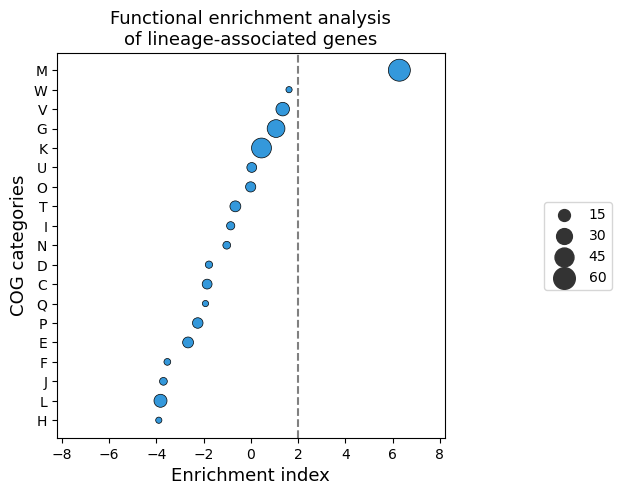

In [27]:
# Make a bubble plot
plt.rcParams["figure.figsize"] = (5, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#3498DB',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Functional enrichment analysis\nof lineage-associated genes', size = 13)
plt.xlabel('Enrichment index', size = 13)
plt.ylabel('COG categories', size = 13)
plt.legend(bbox_to_anchor=(1.45, 0.63))
plt.xlim(-8.2,8.2)

plt.savefig(out_path_1 + 'fig_1b_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Figs. 1c, d, h, i; Supplementary Fig. 1c Comparison of genome size, GC content, and MGEs among Lm lineages

In [28]:
# Load input data
mge = pd.read_csv(data_path_lm + "lm_env_mge.csv")
mge = mge.dropna()
mge.rename(columns={"is_prop": "IS per genome (%)"}, inplace=True)
mge.rename(columns={"tn_prop": "Transposons per genome (%)"}, inplace=True)
mge.rename(columns={"phastest_prop": "Prophage per genome (%)"}, inplace=True)
mge.rename(columns={"plasmid_cnt": "Plasmid count (n)"}, inplace=True)
mge.set_index("Isolate ID", inplace=True)
mge = mge[['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']]
mge_reset = mge.reset_index()

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))
isolate = isolate.drop(columns=["Genome size (bp)", "GC (%)"])
filtered_isolate = isolate[isolate["Phylogroup"].isin(["III", "II", "I"])]

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

def plot_3_box_with_mw_and_swarm(data, x, y, box_pairs, title="", figsize=(4, 6), 
                                 colors=['#CD6155', '#5499C7', '#52BE80'], 
                                 boxplot_kwargs=None, stat_test='Mann-Whitney', out_path=""):
    """
    Plots a combined box plot with statistical annotations and swarm plot.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): The name of the column in 'data' to be used as x-axis groups.
    - y (str): The name of the column in 'data' for the y-axis values.
    - box_pairs (list of tuple): Pairs of groups to compare statistically.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    - colors (list): List of colors for the box plots.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    - stat_test (str): The statistical test to use for annotation.
    - out_path (str): Path to save the output figure.
    """

    # Default boxplot appearance if no additional arguments are given
    if boxplot_kwargs is None:
        boxplot_kwargs = {
            'boxprops': {'edgecolor': 'k', 'linewidth': 2.5, 'facecolor': 'white'},
            'medianprops': {'color': 'k', 'linewidth': 2.5},
            'whiskerprops': {'color': 'k', 'linewidth': 2.5},
            'capprops': {'color': 'k', 'linewidth': 2.5},
            'width': 0.5
        }

    # Define order for plotting
    boxplot_order = ["I", "II", "III"]

    # Remove rows where the y-values are NaN
    data = data.dropna(subset=[y])

    # Ensure there is data left to plot after filtering
    if data.empty:
        print(f"No data to plot for {title} after filtering out NaN rows.")
        return

    # Set figure size
    plt.rcParams["figure.figsize"] = figsize

    # Create figure and axis for plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the boxplot
    sns.boxplot(data=data, x=x, y=y,
                order=boxplot_order,
                palette=dict(zip(boxplot_order, colors)),
                ax=ax,
                **boxplot_kwargs, showfliers=False)

    # Plot the swarmplot
    sns.swarmplot(data=data, x=x, y=y,
                  order=boxplot_order,
                  palette=dict(zip(boxplot_order, colors)),
                  ax=ax)

    # Add statistical annotations using the Annotator from statannotations
    annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, order=boxplot_order)
    annotator.configure(test=stat_test, text_format='full',
                        comparisons_correction='fdr_bh', loc='outside', verbose=2,
                        pvalue_format_string="{:.2g}")

    # Apply the statistical test
    try:
        annotator.apply_and_annotate()
    except ValueError as e:
        print(f"Error in statistical annotation for {title}: {e}")

    # Customize plot appearance
    plt.xticks(rotation=0, size=15)
    plt.ylabel(y, size=15)
    plt.xlabel('Lineage', size=15)
    plt.tight_layout()

    # Replace invalid characters in the title for file naming
    safe_title = title.replace('/', '_').replace('\\', '_') 

    # Save the plot to the specified path
    if out_path:
        plt.savefig(out_path + f'{safe_title}.pdf', format='pdf', dpi=600)

    # Show the plot
    plt.show()

In [30]:
from scipy.stats import kruskal
from collections import defaultdict

# perform KW tests
pval_kw = defaultdict(list)

for columnName, columnData in mge.items():
    L1 = columnData[columnData.index.isin(lm_1)]
    L2 = columnData[columnData.index.isin(lm_2)]
    L3 = columnData[columnData.index.isin(lm_3)]
    u, prob = kruskal(L1, L2, L3)
    pval_kw[columnName].append(prob)

pval_kw

defaultdict(list,
            {'Genome size (bp)': [0.00223127318032463],
             'GC (%)': [5.461498562900649e-16],
             'IS per genome (%)': [1.1938156937673301e-13],
             'Transposons per genome (%)': [9.768379263851714e-08],
             'Prophage per genome (%)': [0.8807613102250279],
             'Plasmid count (n)': [0.06895824113127229]})

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.172e-01 U_stat=2.440e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.153e-03 U_stat=2.699e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.472e-02 (ns) U_stat=8.980e+02


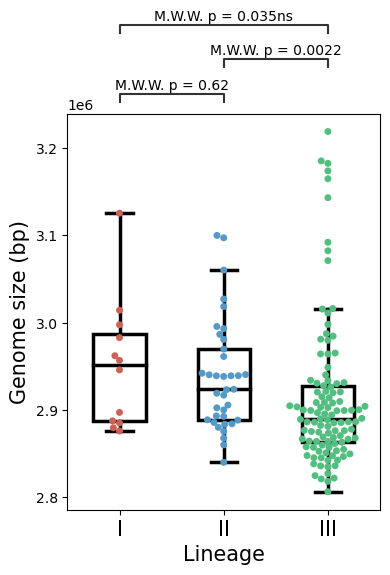

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.552e-01 U_stat=2.835e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.298e-14 U_stat=3.205e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.682e-06 U_stat=1.260e+02


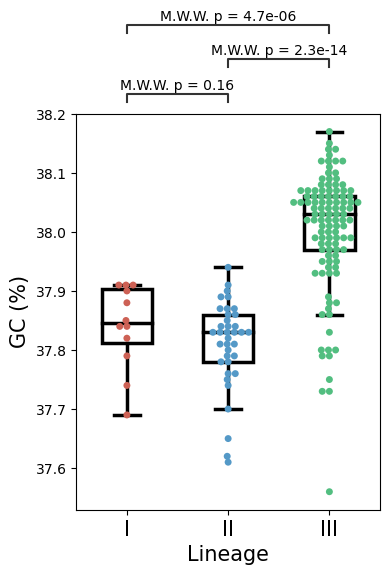

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.395e-06 U_stat=2.400e+01
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.773e-13 U_stat=3.654e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.231e-02 U_stat=9.180e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


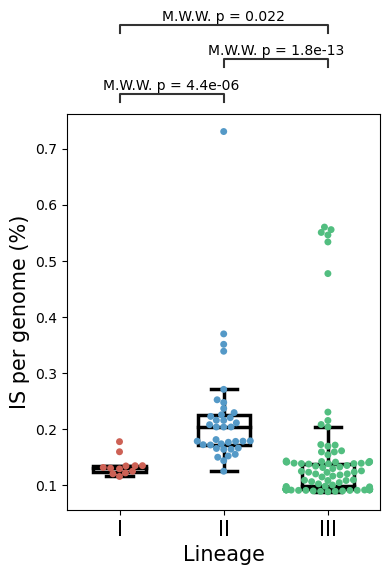

I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.951e-07 U_stat=1.000e+00
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.715e-07 U_stat=3.179e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.741e-01 U_stat=7.570e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


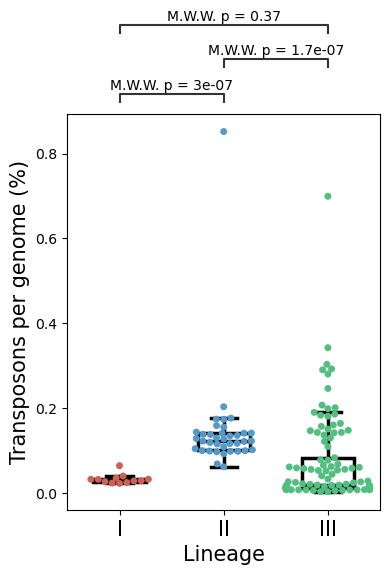

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 51.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.783e-01 U_stat=2.530e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.501e-01 U_stat=1.974e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.516e-01 U_stat=6.910e+02


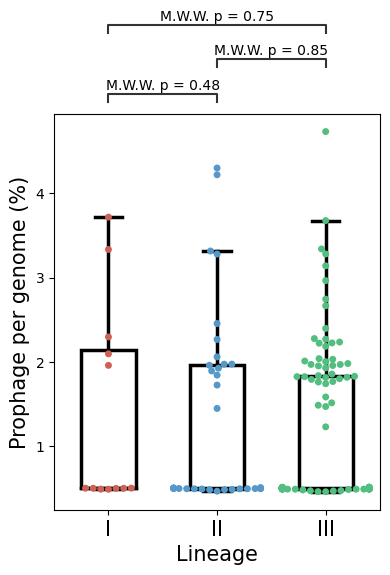

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 45.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 79.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.934e-01 U_stat=2.580e+02
II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.119e-01 U_stat=2.201e+03
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.734e-02 (ns) U_stat=8.245e+02


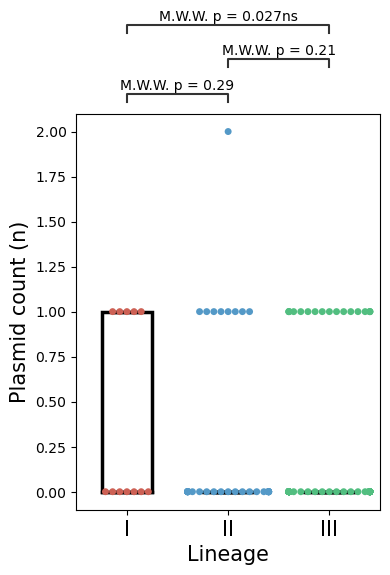

In [31]:
for key, val in pval_kw.items():
    prep_gp = pd.merge(mge_reset, filtered_isolate, on="Isolate ID")
    prep_gp = prep_gp[[f"{key}", "Phylogroup"]]
    temp = prep_gp

    plot_3_box_with_mw_and_swarm(
        data=prep_gp,
        x="Phylogroup",
        y=f"{key}",
        box_pairs=[
            ("I", "II"),
            ("II", "III"),
            ("I", "III"),
        ],
        title=f"{key}",
        out_path=out_path_1
    )

#### Fig. 1e Comparison of Listeria pathogenicity island (LIPI) genes among Lm lineages

In [32]:
# Load packages and data
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']
columns_to_check = df1_s_phylo.columns.difference(['id', 'source', 'Phylogroup'])

# Identify rows that contain values other than 0 or 1
non_binary_rows = df1_s_phylo[columns_to_check].apply(lambda row: row.isin([0, 1]).all(), axis=1)

# Get the rows that have non-binary values
non_binary_data = df1_s_phylo[~non_binary_rows]

In [33]:
# Comparison of virulence gene among Lm lineages
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df1_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df1_s_c_phylo[columns_to_modify] = df1_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [34]:
# Select only 'soil' in 'source' column and create another dataframe
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']

import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table
from collections import defaultdict
import statsmodels.stats.multitest as smt

# Function to perform Fisher's Exact Test for a 2x3 contingency table
def fisher_exact_2x3(table):
    """Performs a Fisher's Exact Test for a 2x3 contingency table."""
    tbl = Table(table)
    result = tbl.test_nominal_association()
    return result.pvalue

# Dictionary to store p-values for each gene
pval = defaultdict(list)

# Genes of interest
genes_of_interest = [
    'prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB', 'LIPI3_llsA', 
    'LIPI3_llsB', 'LIPI3_llsD', 'LIPI3_llsG', 'LIPI3_llsH', 
    'LIPI3_llsP', 'LIPI3_llsX', 'LIPI3_llsY', 'LM9005581_70009', 
    'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 
    'LM9005581_70013', 'LM9005581_70014'
]

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df1_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_vir_s = fdr_sig(pval)

# Print significant columns
sig_vir_s

{'prfA': 0.0,
 'hly': 0.0,
 'LIPI3_llsA': 0.0,
 'LIPI3_llsB': 0.0,
 'LIPI3_llsD': 0.0,
 'LIPI3_llsG': 0.0,
 'LIPI3_llsH': 0.0,
 'LIPI3_llsP': 0.0,
 'LIPI3_llsX': 0.0,
 'LIPI3_llsY': 0.0,
 'LM9005581_70009': 0.0006547147438359935,
 'LM9005581_70010': 0.0006547147438359935,
 'LM9005581_70011': 0.0006547147438359935,
 'LM9005581_70012': 0.0006547147438359935,
 'LM9005581_70013': 0.0006547147438359935,
 'LM9005581_70014': 0.0006547147438359935}

In [35]:
# Proportion heatmap for selected virulence genes
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df1_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_vir_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

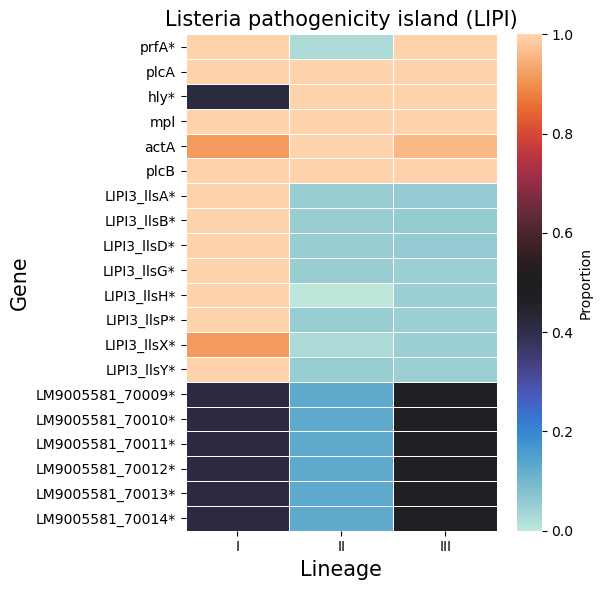

In [36]:
# LIPI
plot_heatmap_gene(heatmap_df, "icefire", title="Listeria pathogenicity island (LIPI)", out_path=out_path_1, 
                        file_title="fig_1e_lipi_lineage", figsize=(6, 6))

#### Fig. 1f Comparison of internalin (inl) genes among Lm lineages

In [37]:
# Select only 'soil' in 'source' column and create another dataframe
df1_s_phylo = df1_s_c_phylo[df1_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df1_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_inl_s = fdr_sig(pval)

# Print significant columns
sig_inl_s

{'inlC': 3.877934932461358e-05,
 'inlF': 0.0,
 'inlG': 1.6196821661651484e-11,
 'inlJ': 4.4348145986194965e-05,
 'inlL': 0.0,
 'inlP3': 1.7763568394002505e-14,
 'inlP4': 6.014625834419955e-11,
 'inlPq': 1.7763568394002505e-14}

In [38]:
# Proportion heatmap for inl genes
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df1_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    #if any([proportion_L1, proportion_L2, proportion_L3]):
    # Modify the key if it is found in sig_vir_s
    if key in sig_inl_s:
        key_modified = key + "*"  # Add asterisk
    else:
        key_modified = key  # No change

    # Append the proportions to the DataFrame using the modified key
    heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

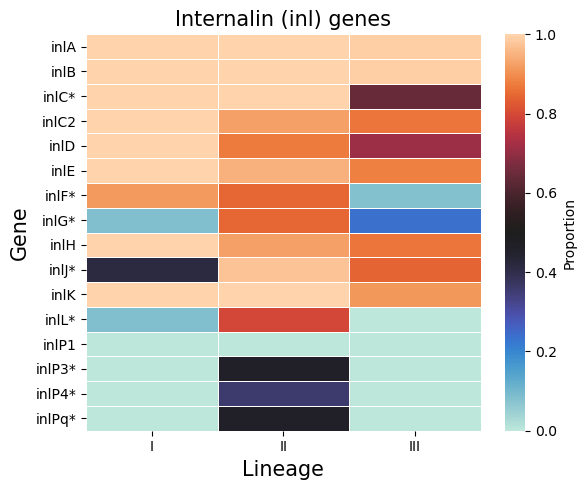

In [39]:
# inl
plot_heatmap_gene(
    heatmap_df, "icefire",
    "Internalin (inl) genes",
    out_path=out_path_1, file_title="fig_1f_inl_lineage", figsize=(6, 5))

#### Fig. 1g Comparison of stress survival islet (SSI) genes among Lm lineages

In [40]:
# Load input data
df2_s_c_phylo = pd.read_csv(data_path_lm + 'stress_merged.csv')

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df2_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df2_s_c_phylo[columns_to_modify] = df2_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [41]:
# Select only 'soil' in 'source' column and create another dataframe
df2_s_phylo = df2_s_c_phylo[df2_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['SSI1_lmo0444', 'SSI1_lmo0445', 'SSI1_lmo0446', 'SSI1_lmo0447', 'SSI1_lmo0448', 'SSI2_lin0464', 'SSI2_lin0465']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df2_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_ssi_s = fdr_sig(pval)

# Print significant columns
sig_ssi_s

{'SSI1_lmo0444': 7.485567721232655e-13,
 'SSI1_lmo0445': 7.485567721232655e-13,
 'SSI1_lmo0446': 7.485567721232655e-13,
 'SSI1_lmo0447': 7.485567721232655e-13,
 'SSI1_lmo0448': 7.485567721232655e-13,
 'SSI2_lin0464': 2.950450994632092e-11,
 'SSI2_lin0465': 2.950450994632092e-11}

In [42]:
# Proportion heatmap for SSI
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df2_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_ssi_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

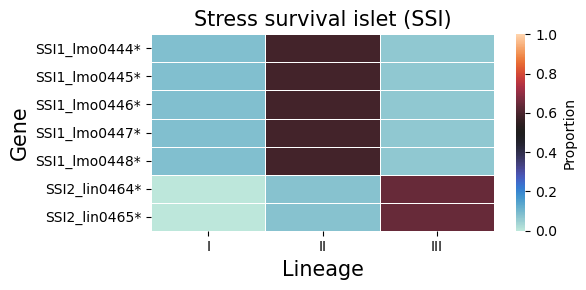

In [43]:
# SSI
plot_heatmap_gene(heatmap_df, "icefire", "Stress survival islet (SSI)", 
                        out_path=out_path_1, file_title="fig_1g_ssi", figsize=(6, 3))

#### Supplementary Fig. 1b Comparison of antibiotic resistance gene (ARG) genes among Lm lineages

In [44]:
# Comparing ARGs between Lm lineages
df4_s_c_phylo = pd.read_csv(data_path_lm + "arg_merged.csv")

# Modify the gene matrix to make it 0 or 1 only (replace values greater than 1 with 1 to indicate overall present)
columns_to_modify = df4_s_c_phylo.columns.difference(['id', 'source', 'Phylogroup'])
df4_s_c_phylo[columns_to_modify] = df4_s_c_phylo[columns_to_modify].applymap(lambda x: 1 if x > 1 else x)

In [45]:
# Select only 'soil' in 'source' column and create another dataframe
df4_s_phylo = df4_s_c_phylo[df4_s_c_phylo['source'] == 'soil']

# Dictionary to store p-values for each column
pval = defaultdict(list)

# Columns of interest
genes_of_interest = ['fosX', 'lin', 'mprF', 'norB', 'sul']

# Loop through each gene and perform Fisher's Exact Test
for gene in genes_of_interest:
    # Group data by Phylogroup and count occurrences of presence (1) and absence (0)
    phylogroups = df4_s_phylo.groupby('Phylogroup')[gene].value_counts().unstack(fill_value=0)

    # Ensure we have 3 groups (lineages) and 2 categories (presence/absence)
    if phylogroups.shape == (3, 2):
        contingency_table = phylogroups.values.T
        p_value = fisher_exact_2x3(contingency_table)
    else:
        p_value = 1
    
    # Store the p-value
    pval[gene].append(p_value)

# Apply FDR correction using your custom fdr_sig function
sig_arg_s = fdr_sig(pval)

# Print significant columns
sig_arg_s

{}

In [46]:
# Proportion heatmap for ARG
heatmap_df = pd.DataFrame(columns=["I", "II", "III"])
i = 0
for key, val in pval.items():
    prep_gp = df4_s_phylo

    # Calculate proportion of occurrences for each group
    total_count_L1 = prep_gp[prep_gp["Phylogroup"] == "LM lineage I"].shape[0]
    total_count_L2 = prep_gp[prep_gp["Phylogroup"] == "LM lineage II"].shape[0]
    total_count_L3 = prep_gp[prep_gp["Phylogroup"] == "LM lineage III"].shape[0]

    count_L1 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage I") & (prep_gp[key] != 0)].shape[0]
    count_L2 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage II") & (prep_gp[key] != 0)].shape[0]
    count_L3 = prep_gp[(prep_gp["Phylogroup"] == "LM lineage III") & (prep_gp[key] != 0)].shape[0]

    proportion_L1 = count_L1 / total_count_L1 if total_count_L1 != 0 else 0
    proportion_L2 = count_L2 / total_count_L2 if total_count_L2 != 0 else 0
    proportion_L3 = count_L3 / total_count_L3 if total_count_L3 != 0 else 0

    # Check if any proportions are non-zero before adding to heatmap_df
    if any([proportion_L1, proportion_L2, proportion_L3]):
        # Modify the key if it is found in sig_vir_s
        if key in sig_arg_s:
            key_modified = key + "*"  # Add asterisk
        else:
            key_modified = key  # No change

        # Append the proportions to the DataFrame using the modified key
        heatmap_df.loc[key_modified] = [proportion_L1, proportion_L2, proportion_L3]

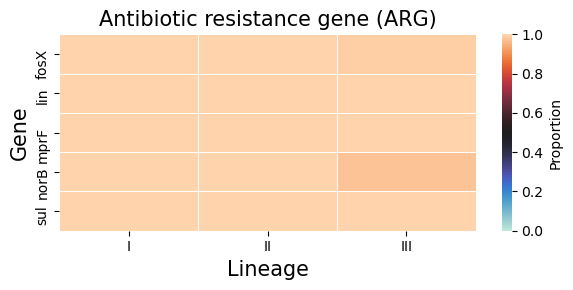

In [47]:
# ARG
plot_heatmap_gene(heatmap_df, "icefire", title="Antibiotic resistance gene (ARG)",
                  out_path=out_path_1, file_title="fig_1b_arg", figsize=(6, 3))

### Fig. 2 | Associations between abiotic environmental factors and the pangenome of Lm

#### Fig. 2a Distribution of Lm lineages in the soil accross the US

In [48]:
# Load input data
env = pd.read_csv(data_path + "environ_all.csv", index_col=0)
env = env.reset_index()
env = env.rename(columns={'Sample ID ': 'Sample ID'})

isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

In [49]:
# Assign groups for samples positive and negative for Lm
lm = isolate[(isolate["Phylogroup"] == "L1") | (isolate["Phylogroup"] == "L2") | (isolate["Phylogroup"] == "L3")]

sample = env.copy()
sample["group"] = np.where(sample.index.isin(lm["Sample ID"]), "pos", "neg")

group = sample[["group"]]

lm_pos = group[group["group"] == "pos"]
lm_neg = group[group["group"] == "neg"]

In [50]:
## Select only Lm and see their phylogroup for crosschecking
isolate_lm = isolate[isolate["Species"] == "L. monocytogenes"]
selected_columns = ["Phylogroup"]

# Create an empty dictionary to store frequency counts for each column
frequency_counts = {}

# Iterate through selected columns and calculate value counts
for column in selected_columns:
    counts = isolate_lm[column].value_counts()
    frequency_counts[column] = counts

# Print the frequency counts
for column, counts in frequency_counts.items():
    print(f"Column: {column}")
    print(counts)
    print("\n")

Column: Phylogroup
Phylogroup
L1    126
L2     39
L3     12
Name: count, dtype: int64




In [51]:
df_map = pd.merge(isolate_lm, env, on='Sample ID', how='left')
df_map = df_map[['Latitude', 'Longitude', 'Phylogroup',]] # 'Sample ID', 'Isolate ID', 
df_map['Phylogroup'] = df_map['Phylogroup'].replace({'L1': 'L3', 'L2': 'L2', 'L3': 'L1'})
df_map['Pos'] = 1

# Create the 'Color' column based on the 'Phylogroup' column
df_map['Color'] = df_map['Phylogroup'].map({
    'L1': '#CD6155',
    'L2': '#5499C7',
    'L3': '#52BE80'
})

# rename the columns
df_map = df_map.rename(columns={'Latitude': 'Lat', 'Longitude': 'Lon', 'Phylogroup': 'Group',})
df_map.to_csv(data_path_lm + 'df_map_lm_lineages.csv', index=False)

/localscratch/ipykernel_252073/360117097.py:67: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_collection(PatchCollection([Polygon(coords, True)], facecolor= poly_color, edgecolor=poly_color, linewidths=1., zorder=2, alpha=0.4))


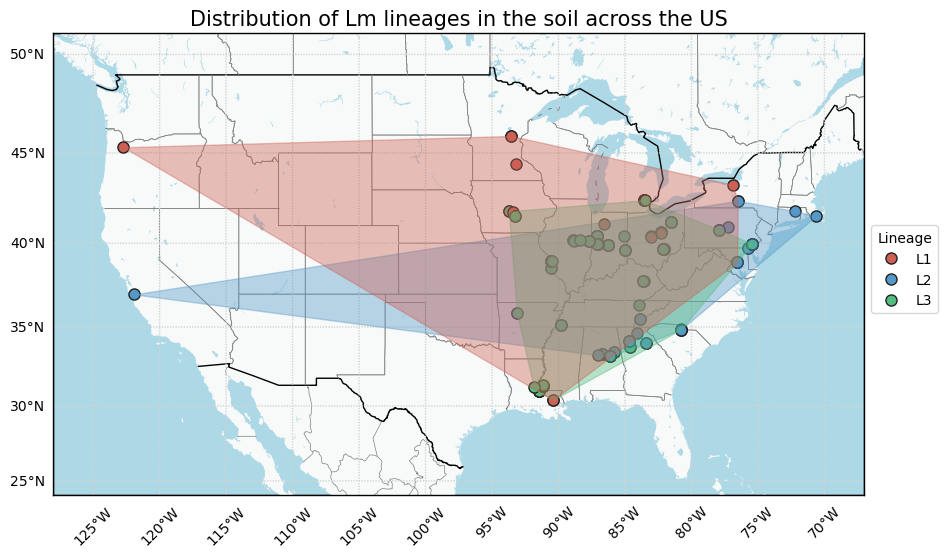

In [52]:
# Plotting the distrubution map
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import csv
import shapefile
import os
from collections import OrderedDict
from shapely.geometry import MultiPoint
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

lats, lons, pos, groups, colors = [],[],[],[],[]

lats = df_map['Lat'].astype(float).tolist()
lons = df_map['Lon'].astype(float).tolist()
pos = [1] * len(df_map)  # Assuming all positions should be filled with '1'
groups = df_map['Group'].astype(str).tolist()
colors = df_map['Color'].astype(str).tolist()

bbox = [24,51,-128, -67]
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
# m.drawcoastlines()
m.drawcountries(linewidth=1, color='black')
m.fillcontinents(color='#F8F9F9',lake_color='lightblue')
m.drawstates(linewidth=0.5, linestyle='solid', color='grey', antialiased=1, ax=None, zorder=None)

m.drawparallels(np.arange(25,55,5), color="lightgray", labels=[1,0,0,0])
# m.drawparallels(np.arange(39.83,40,5),color='#943126', labels=[0,1,0,0],textcolor='#943126', linewidth=1)
m.drawmeridians(np.arange(-125,-65,5), color="lightgray", labels=[0,0,0,1],rotation=45)
# m.drawmeridians(np.arange(-98.58,-95,5),color='#21618C', labels=[0,0,1,0],textcolor='#21618C', linewidth=1)
m.drawmapboundary(fill_color='lightblue')

# home_dir = os.environ['HOME']
# m.readshapefile(os.path.join(home_dir, 'Desktop', 'data', 'timeznp020'),'timeznp020',linewidth=0.5, color='black')

min_marker_size = 8
    
for lon, lat, po, group, color in zip(lons, lats, pos, groups, colors):
    x, y = m(lon, lat)
    msize = po * min_marker_size
    m.plot(x,y,'o', markersize=msize, markeredgecolor='#212121', label=group, color=color)

poly = {}
for lon, lat, color in zip(lons, lats, colors):
    pair = (lon, lat)
    if color not in poly.keys():
        poly[color] = []
    poly[color].append(pair)


for poly_color in poly:
    polygon = MultiPoint(poly[poly_color]).convex_hull
    with open('lm_lineage_polygon_area.txt', 'a') as area:
        area.write(str(polygon.area))
    x, y = polygon.exterior.xy
    x, y = m(x.tolist(), y.tolist())
    coords = []
    for x, y in zip(x, y):
        coords.append((x, y))
    # print(y)
    # m.plot(x,y, color=poly_color, marker=None, fill_color=poly_color)
    ax.add_collection(PatchCollection([Polygon(coords, True)], facecolor= poly_color, edgecolor=poly_color, linewidths=1., zorder=2, alpha=0.4))


# plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
newlabels = []
for l in labels:
    if 'unspecified' in l:
        newlabels.append(l)
    else:
        newlabels.append('$\mathit{%s}$' % l)
by_label = { l: h for l, h in zip(labels, handles) }
by_label = OrderedDict(sorted(by_label.items(), key=lambda t: int(t[0][1:])))
# # by_label_ = OrderedDict(sorted(by_label)
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 0.6), title='Lineage')

plt.title('Distribution of Lm lineages in the soil across the US', size=15)

plt.savefig(out_path_2 + 'fig_2a_lm_lineage_map.pdf', format='pdf', dpi=1200)
plt.show()

In [53]:
# Function to perform pairwise Mann-Whitney test and return p-values
from scipy.stats import mannwhitneyu
from itertools import combinations

def pairwise_mannwhitneyu(data, groups):
    p_values = {}
    group_combinations = combinations(groups, 2)
    
    for group1, group2 in group_combinations:
        try:
            _, p_value = mannwhitneyu(data[group1], data[group2], alternative='two-sided')
            p_values[f"{group1}_{group2}"] = p_value
        except ValueError as e:
            print(f"Error comparing {group1} and {group2}: {e}")
    
    return p_values


def assign_labels(p_values, alpha=0.05):
    groups = sorted(set(group for pair in p_values.keys() for group in pair.split('_')))
    labels = {group: set('a') for group in groups}
    
    def get_p_value(g1, g2):
        pair = f"{g1}_{g2}" if g1 < g2 else f"{g2}_{g1}"
        return p_values.get(pair, 0)
    
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            if get_p_value(group1, group2) < alpha:
                if labels[group1] == labels[group2]:
                    new_label = chr(ord(max(labels[group2])) + 1)
                    labels[group2] = set(new_label)
                    
    for group in groups:
        if all(get_p_value(group, other) >= alpha for other in groups if other != group):
            labels[group] = set(''.join(sorted(set.union(*labels.values()))))
    
    result_labels = {group: ''.join(sorted(label)) for group, label in labels.items()}
    print("Final labels:", result_labels)
    return result_labels

### Supplementary Fig. 2 Abiotic factors significantly different among Lm lineages

In [54]:
# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    "L1": "III",
    "L2": "II",
    "L3": "I",
}
isolate["Phylogroup"] = isolate["Phylogroup"].apply(lambda x: rename_mapping.get(x, x))

# Filtering for L. monocytogenes
monocytogenes_isolate = isolate[isolate["Species"] == "L. monocytogenes"]

monocytogenes_isolate_L1 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "III")
]
monocytogenes_isolate_L2 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "II")
]
monocytogenes_isolate_L3 = monocytogenes_isolate[
    (monocytogenes_isolate["Phylogroup"] == "I")
]

In [55]:
# Load dataframe
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

# perform KW tests to identify env_var that are sig difference among lm lineages
from scipy.stats import kruskal
from collections import defaultdict

pval = defaultdict(list)

for columnName, columnData in env.items():
    L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
    L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
    L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]
    u, prob = kruskal(L1, L2, L3)
    pval[columnName].append(prob)

sig_env = fdr_sig(pval)
sorted_sig_env = sorted(sig_env.items(), key=lambda x: x[1])
len(sig_env)
sorted_sig_env

[('Precipitation (mm)', 1.1240707573385708e-06),
 ('Forest (%)', 6.781597153860129e-05),
 ('Pasture (%)', 0.00015436229110401972),
 ('Longitude', 0.000157093500993852),
 ('Shrubland (%)', 0.000157093500993852),
 ('Min temperature (C)', 0.00025979434290305267),
 ('Organic matter (%)', 0.0003498189841241714),
 ('Max temperature (C)', 0.0003498189841241714),
 ('Latitude', 0.000484020685480983),
 ('Aluminum (mg/Kg)', 0.00234491985755738),
 ('pH', 0.00380154554207482),
 ('Magnesium (mg/Kg)', 0.00380154554207482),
 ('Open water (%)', 0.00380154554207482),
 ('Sodium (mg/Kg)', 0.004231549442388078),
 ('Calcium (mg/Kg)', 0.009682732139841757),
 ('Total carbon (%)', 0.010135066067556986),
 ('Moisture', 0.014255358336640307),
 ('Wetland (%)', 0.014255358336640307),
 ('Sulfur (mg/Kg)', 0.02522383195625056),
 ('Iron (mg/Kg)', 0.02566879485114306),
 ('Total nitrogen (%)', 0.03050507702476023),
 ('Wind speed (m/s)', 0.04404522788671893)]

In [56]:
# Reset index on the env DataFrame so that we can merge based in Sample ID
env_reset = env.reset_index()
env_reset = env_reset.rename(columns={"Sample ID ": "Sample ID"})

# Filter the isolate DataFrame to keep only rows with 'LM lineage III', 'LM lineage II', 'LM lineage I' in 'Phylogroup'
filtered_isolate = isolate[
    isolate["Phylogroup"].isin(["III", "II", "I"])
]

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.492e-04 U_stat=1.374e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.991e-04 U_stat=3.030e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.638e-04 U_stat=1.022e+03


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


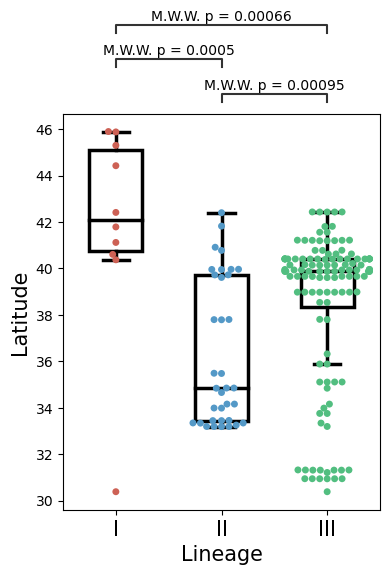

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.604e-07 U_stat=3.394e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.158e-03 U_stat=7.600e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.095e-01 U_stat=4.305e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


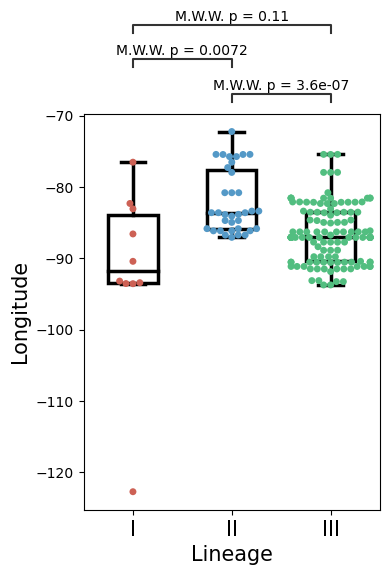

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.473e-03 U_stat=2.898e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.944e-01 U_stat=1.950e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.663e-03 U_stat=9.305e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 24.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


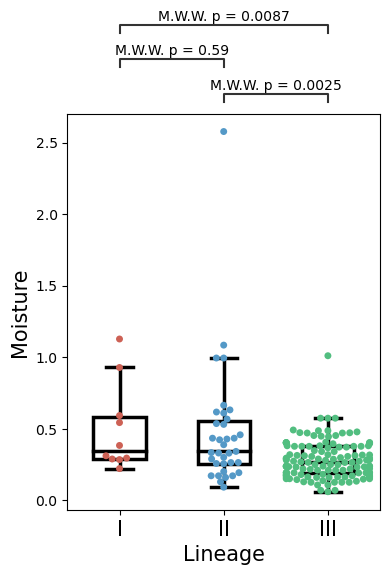

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.600e-03 U_stat=2.802e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.604e-01 U_stat=2.090e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.330e-03 U_stat=9.275e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


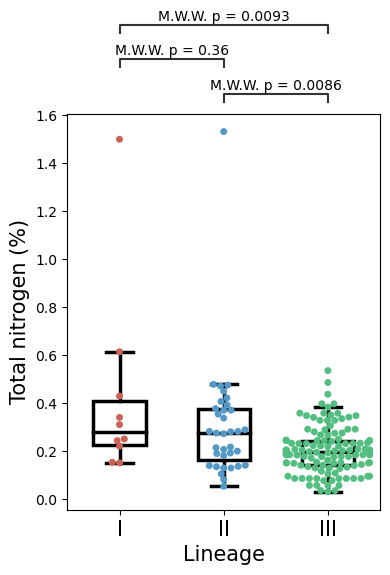

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.930e-05 U_stat=3.128e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.527e-01 U_stat=1.470e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.795e-01 U_stat=7.790e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


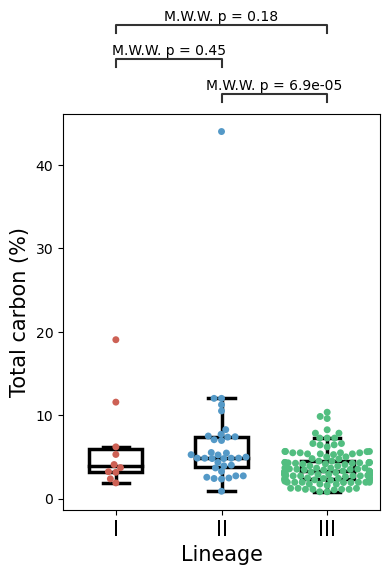

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.813e-05 U_stat=1.202e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.043e-01 U_stat=2.350e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.117e-01 U_stat=4.720e+02


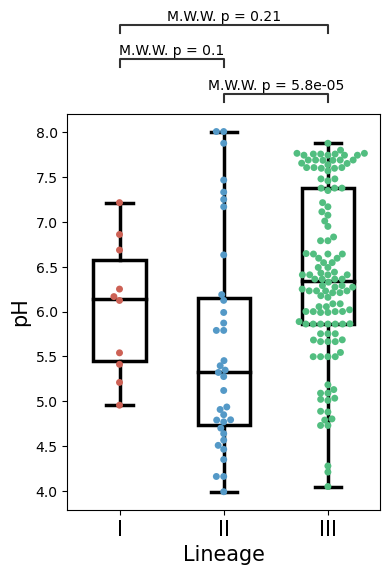

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.628e-06 U_stat=3.300e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.135e-01 U_stat=1.560e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.474e-02 U_stat=9.085e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


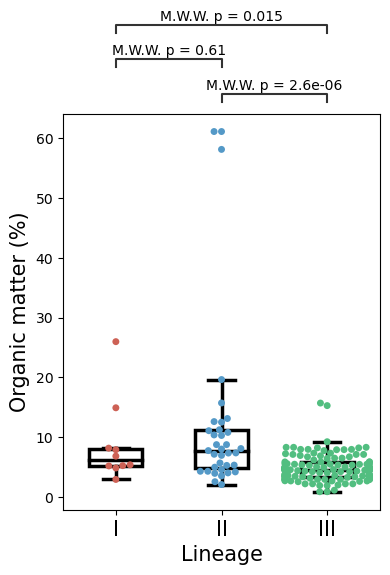

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.396e-05 U_stat=3.216e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.262e-02 U_stat=9.100e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.095e-01 U_stat=6.645e+02


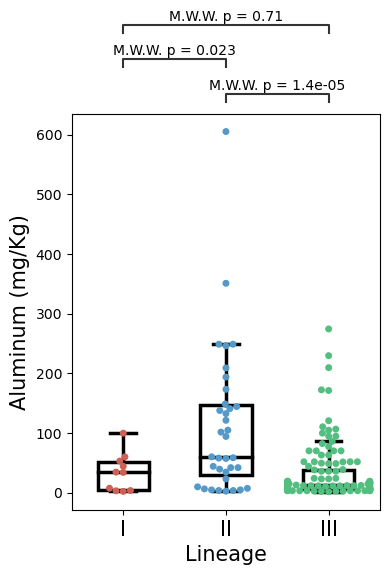

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 39.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.470e-03 U_stat=1.466e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.155e-02 U_stat=2.680e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.339e-01 U_stat=7.975e+02


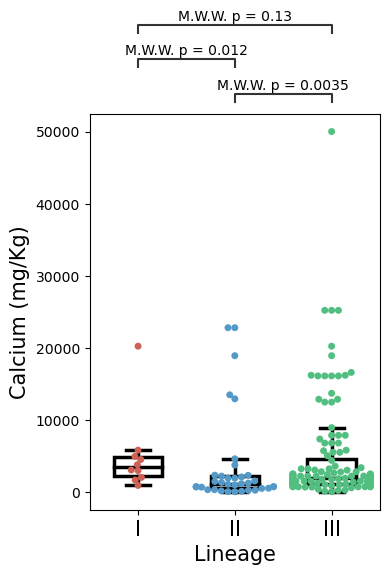

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.471e-04 U_stat=2.982e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.206e-01 U_stat=1.450e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.296e-01 U_stat=7.995e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


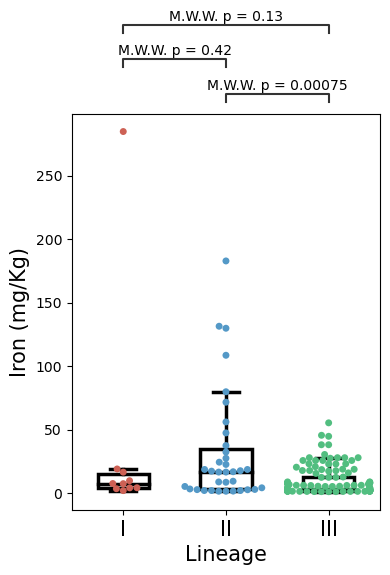

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.194e-02 U_stat=1.720e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.462e-04 U_stat=2.990e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.254e-03 U_stat=1.002e+03


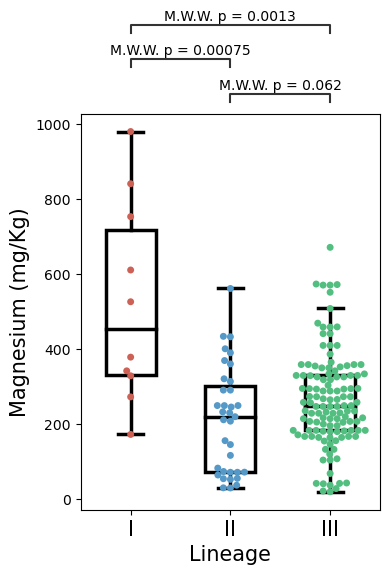

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.968e-05 U_stat=3.106e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.527e-01 U_stat=2.030e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.544e-02 U_stat=9.065e+02


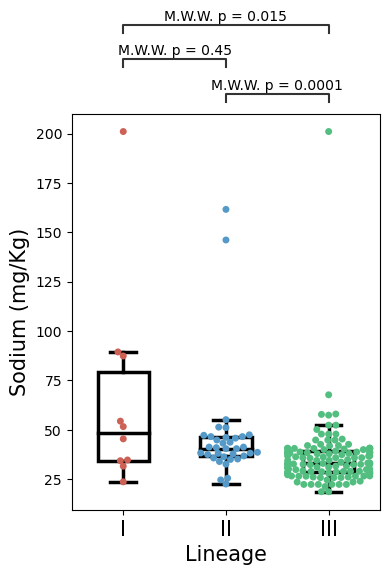

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.941e-04 U_stat=3.008e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.591e-01 U_stat=1.680e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.426e-02 (ns) U_stat=8.705e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


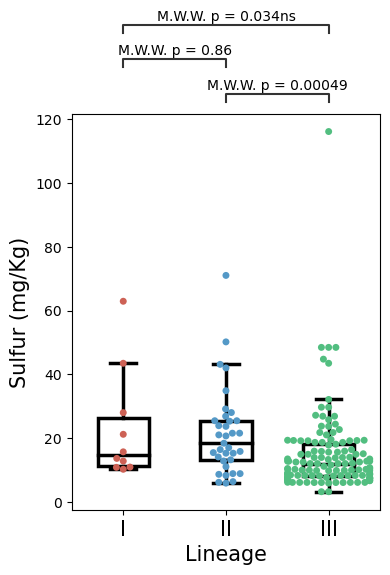

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.794e-10 U_stat=3.660e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.320e-05 U_stat=3.150e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.459e-01 U_stat=4.480e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


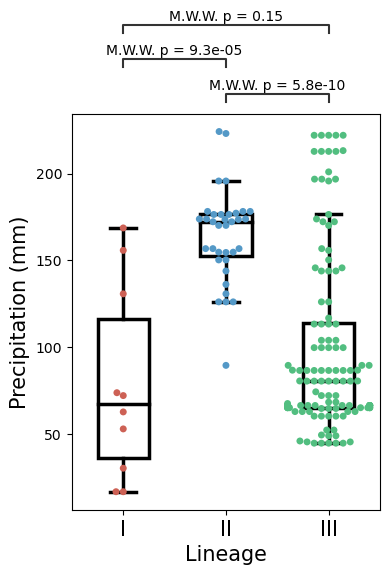

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.936e-06 U_stat=3.280e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.675e-03 U_stat=5.950e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.290e-02 U_stat=4.080e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


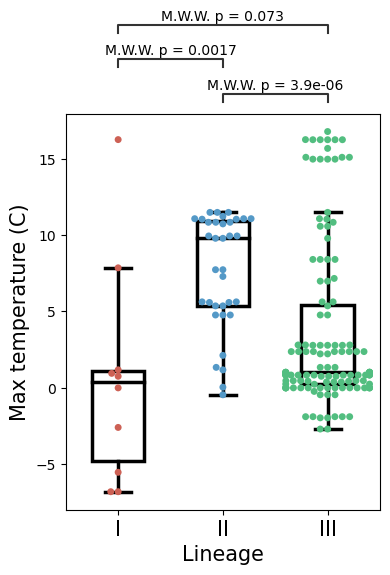

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.359e-07 U_stat=3.354e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.283e-03 U_stat=7.450e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.676e-02 U_stat=3.850e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


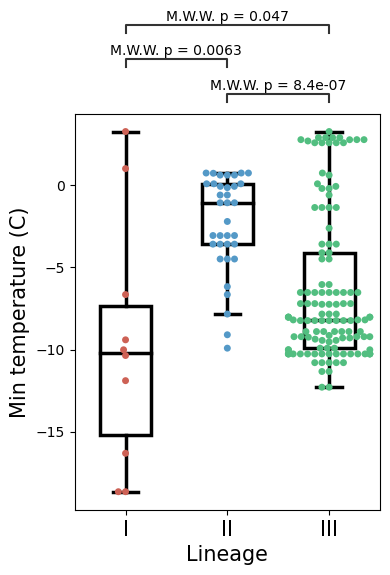

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.510e-04 U_stat=1.310e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.389e-01 U_stat=2.105e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.553e-01 U_stat=6.420e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


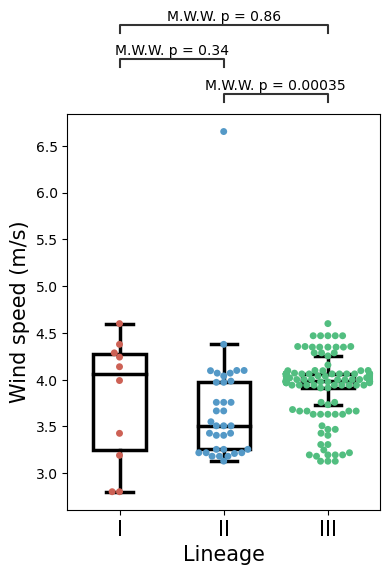

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.691e-05 U_stat=1.210e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.517e-01 U_stat=2.280e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.898e-01 U_stat=4.945e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


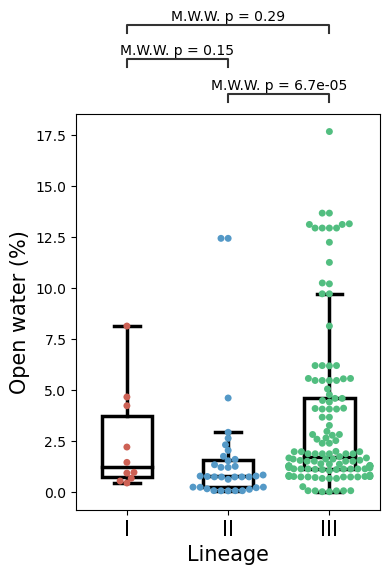

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.968e-08 U_stat=3.456e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.972e-04 U_stat=4.200e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.133e-01 U_stat=4.325e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


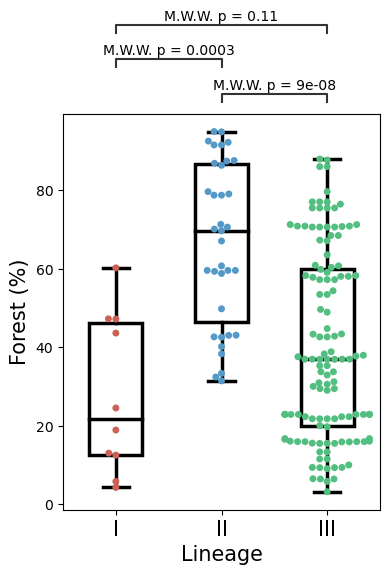

II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.202e-07 U_stat=3.444e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.552e-03 U_stat=6.400e+01
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.364e-01 U_stat=6.935e+02


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


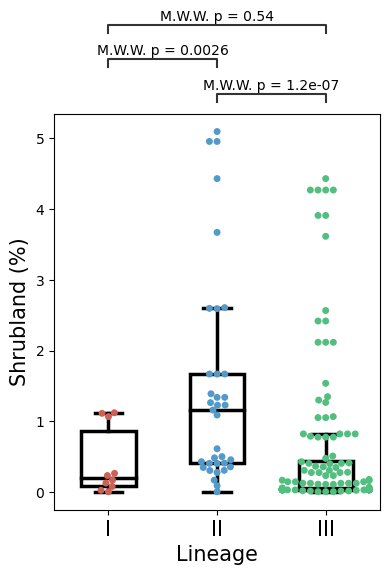

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.102e-07 U_stat=9.390e+02
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.358e-04 U_stat=3.150e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.162e-01 U_stat=7.165e+02


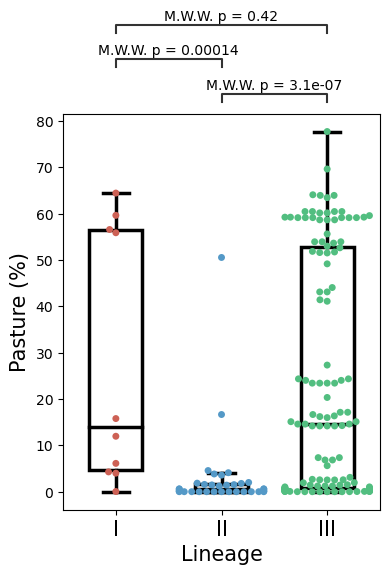

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


II vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.497e-03 U_stat=1.536e+03
I vs. II: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.335e-03 U_stat=2.930e+02
I vs. III: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.499e-02 U_stat=8.695e+02


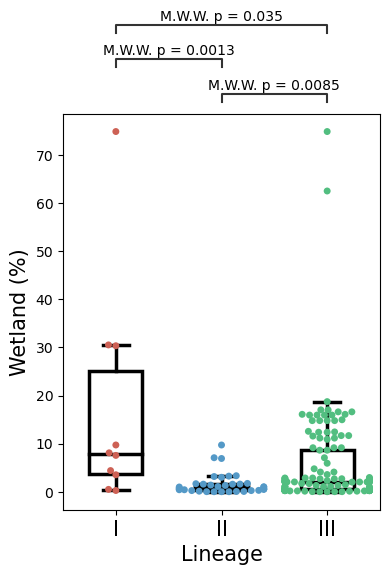

In [57]:
for key, val in sig_env.items():
    prep_gp = pd.merge(env_reset, filtered_isolate, on="Sample ID")
    prep_gp = prep_gp[[f"{key}", "Phylogroup"]]

    plot_3_box_with_mw_and_swarm(
        data=prep_gp,
        x="Phylogroup",
        y=f"{key}",
        box_pairs=[
            ("III", "II"),
            ("III", "I"),
            ("II", "I"),
        ],
        title=f"{key}",
        out_path=out_path_2
    )

### Supplementary Fig. 3 Multidimensional scaling (MDS) on abiotic variables among Lm lineages

In [58]:
# Function for making ellipse
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, linewidth=2.0, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [59]:
# Filtering for samples with only one Phylogroup
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
filtered_isolate = monocytogenes_isolate.groupby('Sample ID').filter(lambda x: x['Phylogroup'].nunique() == 1)
filtered_isolate = filtered_isolate.drop_duplicates(subset='Sample ID')

# Reset the current index and keep it as a column
filtered_isolate = filtered_isolate.reset_index()

# Set 'Sample ID' as the new index
filtered_isolate = filtered_isolate.set_index('Sample ID')

#Filtering for monocytogenes
monocytogenes_isolate = filtered_isolate[filtered_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

sample = env.copy()
merged_df_2 = pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)
group = merged_df_2[['Phylogroup']].copy()
group.rename(columns={'Phylogroup': 'group'}, inplace=True)

In [60]:
# Use environmental variables as input for MDS
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()
env_df = pd.merge(env, group, left_index=True, right_index=True)
env_df = env_df.drop("group", axis=1)

In [61]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(env_df) # Change to sig_env_df if wanna see only significant abiotic variable

# Compute the distance matrix
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Perform MDS
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [62]:
# Classify samples into groups based on presence of different lineages
mds_2d_df = pd.DataFrame(mds_coordinates).set_index(env_df.index)
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)

In [63]:
# Perform PERMANOVA test on grouping
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib.patches import Ellipse

grouping = list(mds_group['group'])

symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=env_df.index)

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     107
number of groups                  3
test statistic             6.703212
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


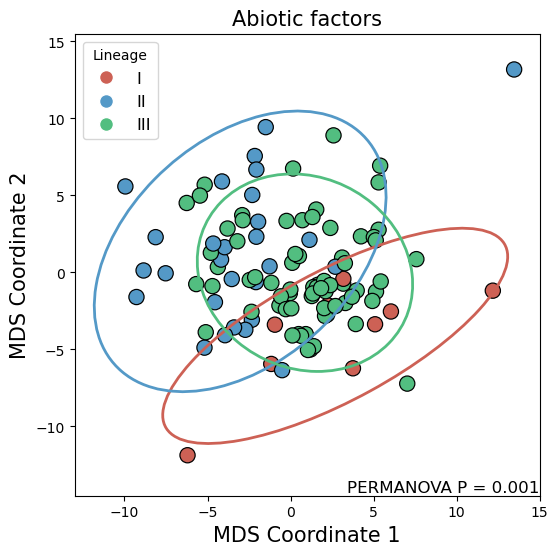

In [64]:
colors = ['#CD6155', '#5499C7', '#52BE80']
hue_order = ['I', 'II', 'III']

# Create the plot
plt.rcParams["figure.figsize"] = (6, 6)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')
    e.set_label(lineage)

# Setting the plot title and labels
ax.set_title('Abiotic factors', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)

# Setting the plot limits
plt.xlim(-13, 15)
plt.ylim(-14.5, 15.5)

# Adding text for Permanova p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)

# Removing default legend
ax.legend_.remove()

# Creating custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='I', markerfacecolor='#CD6155', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='II', markerfacecolor='#5499C7', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='III', markerfacecolor='#52BE80', markersize=10)]

# Adding custom legend outside the plot
plt.legend(handles=legend_elements, loc='upper left', title='Lineage', fontsize=12)

plt.savefig(out_path_2 + 'fig_2b_mds_env.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()

#### Fig. 2b Redundancy Analysis (RDA) between the accessory genome of Lm and abiotic environmental factors

In [65]:
# Load input data
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()
gen_pre_abs = gen_pre_abs.rename_axis('Isolate ID')

# Reset index and select relevant columns from lm_isolate
lm_sample = lm_isolate.reset_index()
lm_sample = lm_sample[['Isolate ID', 'Sample ID']]

# Load environmental data
env = pd.read_csv(data_path + 'environ_all.csv', index_col=0)
env = env.dropna()

# Merge with lm_sample
env_isolate = lm_sample.merge(env, left_on='Sample ID', right_index=True, how='left', suffixes=('', '_env'))

# Set 'Isolate ID' as the index and drop 'Sample ID' column
env_isolate.set_index('Isolate ID', inplace=True)
env_isolate.drop(columns=['Sample ID'], inplace=True)

# Drop rows with NaN values
env_isolate = env_isolate.dropna()

# Drop rows not present in either gen_pre_abs or env_isolate
common_index = gen_pre_abs.index.intersection(env_isolate.index)
gen_pre_abs_env = gen_pre_abs.loc[common_index]
env_isolate = env_isolate.loc[common_index]

# Remove title for index
env_isolate.index.name = None
env_isolate.columns.name = None
gen_pre_abs_env.index.name = None
gen_pre_abs_env.columns.name = None

# Drop columns that consist only zeros in 'gen_pre_abs' df
column_totals = gen_pre_abs_env.sum(axis=0)

## Identify columns with a total of 0
columns_with_zero_total = column_totals[column_totals == 0].index

# Drop the columns that consist only of zeros
gen_pre_abs_env = gen_pre_abs_env.drop(columns=columns_with_zero_total)

# Drop columns that consist all 'one' in 'gen_pre_abs_env' df - core gene
column_totals_169 = gen_pre_abs_env.sum(axis=0)
columns_with_169_total = column_totals_169[column_totals_169 == 169].index
gen_pre_abs_env_accessory = gen_pre_abs_env.drop(columns=columns_with_169_total)

# Export DataFrame to CSV
gen_pre_abs_env_accessory.to_csv(data_path_lm + 'gen_pre_abs_env.csv', index=True)
env_isolate.to_csv(data_path_lm + 'env_isolate.csv', index=True)

# Merge the two dataframes based on the index of gen_pre_abs
merged_df = gen_pre_abs_env.merge(env_isolate, left_index=True, right_index=True)

print(len(gen_pre_abs_env.columns))
print(len(gen_pre_abs_env_accessory.columns))

5818
3488


In [66]:
# Scale the environmental variables before performing DCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the DataFrame
scaled_env = pd.DataFrame(scaler.fit_transform(env_isolate), 
                          columns=env_isolate.columns,
                          index=env_isolate.index)

In [67]:
# Perform detrended correspondence analysis (DCA) to determine RDA or CCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter

# Import required R packages
vegan = importr('vegan')

# Convert pandas DataFrames to R dataframes
with localconverter(pandas2ri.converter):
    r_gen_pre_abs = pandas2ri.py2rpy(gen_pre_abs_env_accessory)
    r_scaled_env_variables = pandas2ri.py2rpy(scaled_env)

# Perform DCA
dca_result = vegan.decorana(r_gen_pre_abs)

# Extract isolate scores (row projection)
isolate_scores = pd.DataFrame(np.array(dca_result.rx2('rproj')),
                           index=gen_pre_abs_env_accessory.index, 
                           columns=['DCA1', 'DCA2', 'DCA3', 'DCA4'])

# Extract gene scores (column projections)
gene_scores = pd.DataFrame(np.array(dca_result.rx2('cproj')),
                              index=gen_pre_abs_env_accessory.columns, 
                              columns=['DCA1', 'DCA2', 'DCA3', 'DCA4'])

# Calculate eigenvectors
eigenvalues = np.array(dca_result.rx2('evals'))

# Project environmental variables onto DCA axes
env_fit = vegan.envfit(dca_result, r_scaled_env_variables)
env_vectors = pd.DataFrame(np.array(env_fit.rx2('vectors').rx2('arrows')), 
                           index=scaled_env.columns, 
                           columns=['DCA1', 'DCA2'])

# The length of the first DCA axis (DCA1)
length_dca1 = eigenvalues[0]
print(f"Length of the first DCA axis (DCA1): {length_dca1:.3f}")

Length of the first DCA axis (DCA1): 0.165


In [68]:
# Feature selection for env_var to be included in RDA using L1 regularization (Lasso)
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale data using RobustScaler - account for outliers, more robust
scaler = RobustScaler()
X = scaler.fit_transform(env_isolate)

# Perform L1 regularization (Lasso)
lasso = Lasso(alpha=0.1, max_iter=10000, tol=1e-3)
lasso_selector = lasso.fit(X, gen_pre_abs_env_accessory.sum(axis=1)) # Using gene richness as a proxy target
lasso_support = lasso_selector.coef_ != 0
lasso_features = env_isolate.columns[lasso_support]
#print("Lasso selected features:", lasso_features)

# Create a new dataframe with selected features
selected_env = env_isolate[list(lasso_features)]
print(len(env_isolate.columns))
print(len(selected_env.columns))

34
31


In [69]:
# Performing RDA between environmental variables and pangenome variation (Lm accessory genes)
import pandas as pd
from skbio.stats.ordination import rda

# Perform RDA between selected environmental variables and pangenome variation (Lm accessory genes)
rda_result = rda(gen_pre_abs_env_accessory, selected_env, scale_Y=False, scaling=1)
RDA1 = rda_result.proportion_explained[0]
RDA2 = rda_result.proportion_explained[1]
total_explained = RDA1 + RDA2
print(f"Total Explained: {total_explained:.2%}")

Total Explained: 5.00%


In [70]:
import pandas as pd

# Load the data
gen_pre_abs_env = pd.read_csv(data_path_lm + "gen_pre_abs_env.csv", index_col=0)

# Rename L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

# Filter for monocytogenes
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
monocytogenes_isolate = monocytogenes_isolate.reset_index()
monocytogenes_isolate = monocytogenes_isolate.set_index('Isolate ID')
monocytogenes_isolate = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

# Merge with sample data
sample = gen_pre_abs_env.copy()
merged_df_2= pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)

# Create lm_lineage and ensure it is a copy
lm_lineage = merged_df_2[['Phylogroup']].copy()
lm_lineage.rename(columns={'Phylogroup': 'Lineage'}, inplace=True)

In [71]:
# Extracting RDA axes 1 and 2 for machine learning
sample_scores = rda_result.samples

# Extract RDA1 and RDA2 scores
RDA1_scores = sample_scores.iloc[:, 0]  # First column for RDA1
RDA2_scores = sample_scores.iloc[:, 1]  # Second column for RDA2

# Combine RDA1 and RDA2 scores into a DataFrame if needed
rda_scores_df = sample_scores.loc[:, ['RDA1', 'RDA2']] = sample_scores.iloc[:, [0, 1]]

# Combine the data and export for ML 
env_isolate_rda = pd.merge(selected_env, rda_scores_df, left_index=True, right_index=True)
env_isolate_rda = env_isolate_rda.reset_index(drop=False)
env_isolate_rda = env_isolate_rda.rename(columns={'index': 'isolate_id'})
env_isolate_rda.to_csv(out_path_oth + "tab_1_env_isolate_rda_accessory.csv", index=False)

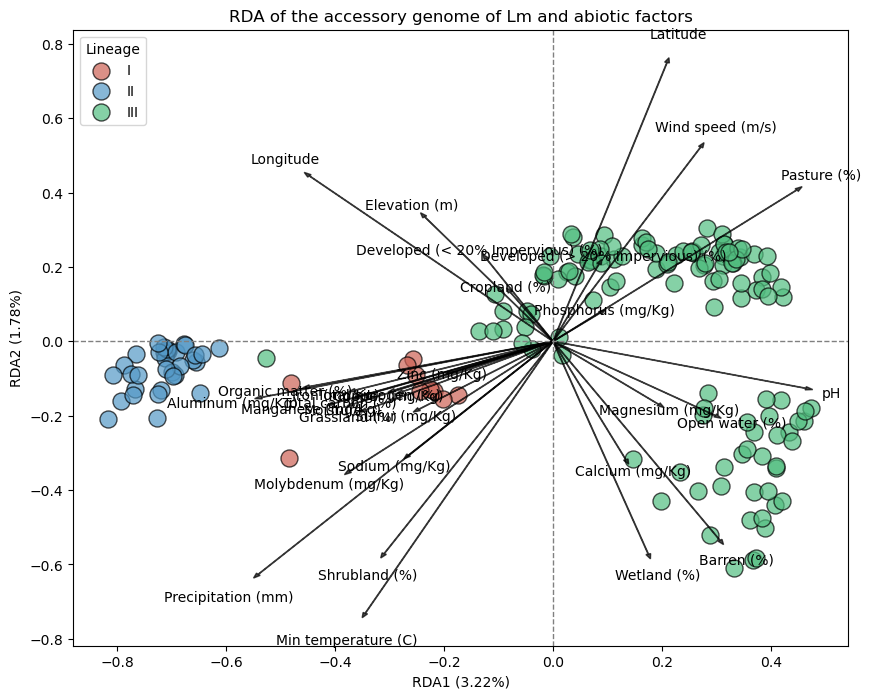

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each lm_lineage
color_dict = {'I': '#CD6155', 'II': '#5499C7', 'III': '#52BE80'}

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the isolates
for group in color_dict.keys():
    sns.scatterplot(
        x=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA1'], 
        y=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA2'], 
        s=150, edgecolor='black', alpha=0.7, color=color_dict[group], label=f'{group}'
    )

# Plot arrows for environmental variables
for i in range(rda_result.biplot_scores.shape[0]):
    plt.arrow(0, 0, rda_result.biplot_scores['RDA1'][i], rda_result.biplot_scores['RDA2'][i], 
              color='black', alpha=0.7, head_width=0.009)
    plt.text(rda_result.biplot_scores['RDA1'][i]*1.1, rda_result.biplot_scores['RDA2'][i]*1.1, 
             rda_result.biplot_scores.index[i], color='black', ha='center', va='center')
    
# Add labels and title
plt.xlabel(f"RDA1 ({rda_result.proportion_explained[0]:.2%})")
plt.ylabel(f"RDA2 ({rda_result.proportion_explained[1]:.2%})")
plt.title("RDA of the accessory genome of Lm and abiotic factors")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')

# Add legend
plt.legend(title='Lineage', loc='upper left')

# Show plot
plt.grid(False)
plt.savefig(out_path_2 + 'fig_2b_rda_env_pan.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 2d Frequency of abiotic factors linked to lineage-associated genes

In [73]:
# Identifying abiotic-linked genes
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sig_gene = list(sig_gene) 

gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
sig_gen_pre_abs = gen_pre_abs.loc[sig_gene]
sig_gen_pre_abs = sig_gen_pre_abs.transpose()
sig_gen_pre_abs = sig_gen_pre_abs.rename_axis('Isolate ID')

# Selecting sig_env variable from env_isolate
sig_env_isolate = env_isolate[env_isolate.columns.intersection(list(sig_env.keys()))]

# Drop rows not present in either gen_pre_abs or sig_env_isolate
common_index = sig_gen_pre_abs.index.intersection(sig_env_isolate.index)
sig_gen_pre_abs = sig_gen_pre_abs.loc[common_index]
sig_env_isolate = sig_env_isolate.loc[common_index]

# Initialize an empty DataFrame to store the raw p-values
raw_pval = pd.DataFrame()

# Initialize an empty DataFrame to store significant results after FDR correction
fdr_corrected_results = pd.DataFrame()

# Iterate through each gene in sig_gen_pre_abs
for gene in sig_gen_pre_abs.columns:
    # Get the rows where the gene is present (1) and absent (0)
    present_rows = sig_gen_pre_abs[sig_gen_pre_abs[gene] == 1].index
    absent_rows = sig_gen_pre_abs[sig_gen_pre_abs[gene] == 0].index
    
    # Initialize lists to store Mann-Whitney test results
    u_values = []
    p_values = []
    
    # Iterate through each environmental variable in sig_env_isolate
    for env in sig_env_isolate.columns:
        # Get the environmental values for the present and absent groups
        present_env = sig_env_isolate.loc[present_rows, env]
        absent_env = sig_env_isolate.loc[absent_rows, env]
        
        # Perform Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(present_env, absent_env)
        
        # Append the results to the lists
        u_values.append(u_statistic)
        p_values.append(p_value)
    
    # Create a DataFrame to store the Mann-Whitney test results for each env_var
    mw_results = pd.DataFrame({
        'Gene': gene,
        'Env_var': sig_env_isolate.columns,
        'U_Value': u_values,
        'P_Value': p_values
    })
    
    # Concatenate the raw p-values results
    raw_pval = pd.concat([raw_pval, mw_results])

# Perform False Discovery Rate (FDR) correction on the combined p-values
rejected, p_corrected, _, _ = multipletests(raw_pval['P_Value'], alpha=0.05, method='fdr_bh')

# Add the FDR-corrected p-values to the raw_pval DataFrame
raw_pval['FDR_Corrected_P_Value'] = p_corrected
raw_pval['Rejected'] = rejected

# Filter for significant results after FDR correction
fdr_adjusted_pval = raw_pval[raw_pval['Rejected']]

# Select columns for the FDR corrected results
fdr_adjusted_env_pval = fdr_adjusted_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Reorder the raw_pval_results columns as per your requirement
raw_env_pval = raw_pval[['Gene', 'Env_var', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

# Sort significant_results based on 'FDR_Corrected_P_Value' column
fdr_adjusted_env_pval_sorted = fdr_adjusted_env_pval.sort_values(by='FDR_Corrected_P_Value')
fdr_adjusted_env_pval_sorted.to_csv(out_path_supp + 'tab_s1_sig_env_gene.csv')

In [74]:
print(len(sig_env))
print(len(sig_gene))
print(len(raw_env_pval))
print(len(fdr_adjusted_env_pval))

22
670
14740
5429


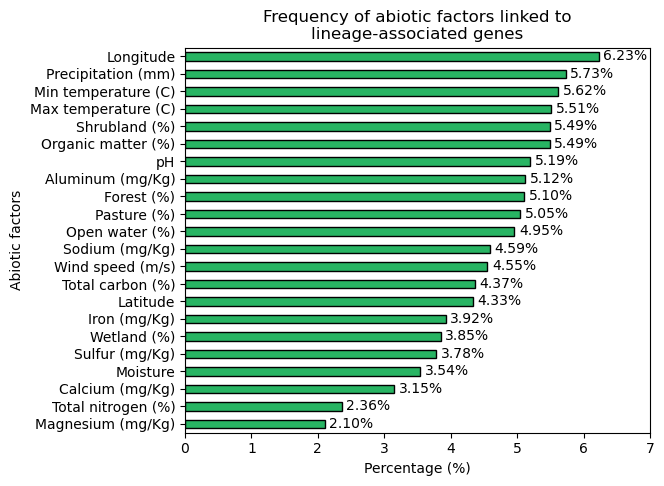

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

gen_env = pd.read_csv(out_path_supp + 'tab_s1_sig_env_gene.csv', index_col=0)
env_counts = gen_env['Env_var'].value_counts()
env_prop = (env_counts / env_counts.sum()) * 100

# Sorting the proportions in descending order
env_prop_sorted = env_prop.sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(6, 5))
bars = env_prop_sorted.plot(kind='barh', color='#28B463', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel('Abiotic factors')
plt.title('Frequency of abiotic factors linked to\nlineage-associated genes')

# Setting x-axis limits
plt.xlim(0, 7)

# Adding percentage values at the end of the bars
for index, value in enumerate(env_prop_sorted):
    plt.text(value + 0.07, index, f'{value:.2f}%', va='center', ha='left', color='black')  # Adjust value - 2 as needed to move text

# Save the figure
plt.savefig(out_path_2 + 'fig_2d_env_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Supplementary Fig. 4 Prevalence of COG functional categories of abiotic-linked lineage genes

In [76]:
# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Get the unique values from the 'Gene' column
unique_genes = gen_env['Gene'].unique()

# Convert the unique values into a DataFrame with 'query_name' as the column name
gen_env_df = pd.DataFrame(unique_genes, columns=['query_name'])

# Set 'query_name' as the index of the DataFrame
gen_env_df.set_index('query_name', inplace=True)

# Merge gen_env_df with gen_annot using the 'query_name' index from gen_env_df
gen_env_annotated = gen_env_df.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_env_cog_split = split_rows(gen_env_annotated, 'COG Functional Category')

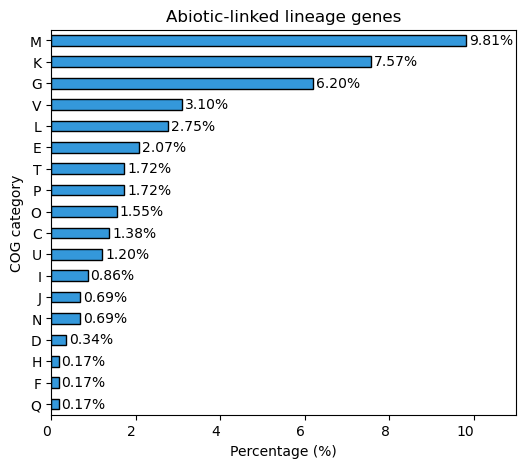

In [77]:
cog_env_counts = gen_env_cog_split['COG Functional Category'].value_counts()
cog_env_prop = (cog_env_counts / cog_env_counts.sum()) * 100

# Sorting the proportions in descending order
cog_env_prop_sorted = cog_env_prop.sort_values(ascending=True)
cog_env_prop_sorted = cog_env_prop_sorted[cog_env_prop_sorted.index != 'S']

# Plotting the bar chart
plt.figure(figsize=(6, 5))
cog_env_prop_sorted.plot(kind='barh', color='#3498DB', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel('COG category')
plt.title('Abiotic-linked lineage genes')
plt.xticks(rotation=0, ha='right')

# Setting x-axis limits
plt.xlim(0, 11)

# Adding percentage values at the end of the bars
for index, value in enumerate(cog_env_prop_sorted):
    plt.text(value + 0.07, index, f'{value:.2f}%', va='center', ha='left', color='black')  # Adjust value - 2 as needed to move text

plt.savefig(out_path_2 + 'fig_2e_cog_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Fig. 2e Abiotic-linked lineage genes with the lowest P-values

Presence v.s. Absence: Custom statistical test, P_val:4.042e-14


/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 400x600 with 0 Axes>

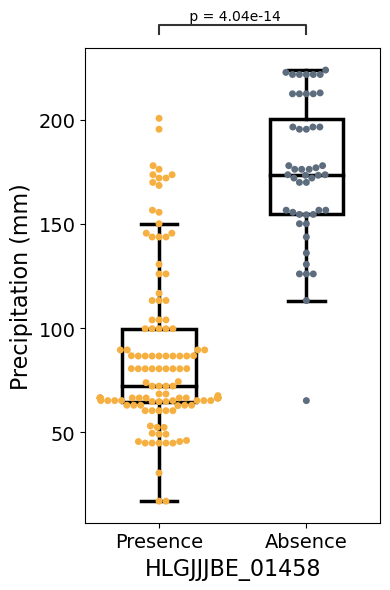

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Presence v.s. Absence: Custom statistical test, P_val:4.042e-14


<Figure size 400x600 with 0 Axes>

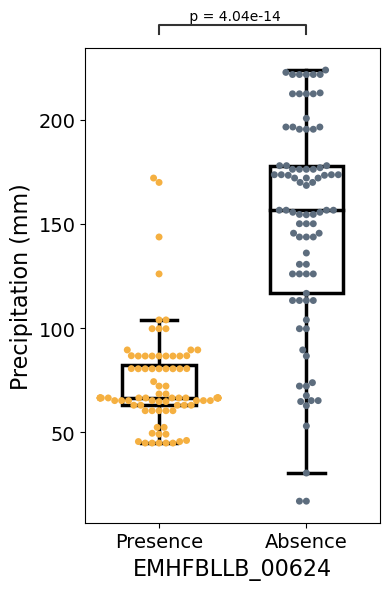

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Presence v.s. Absence: Custom statistical test, P_val:6.586e-14


<Figure size 400x600 with 0 Axes>

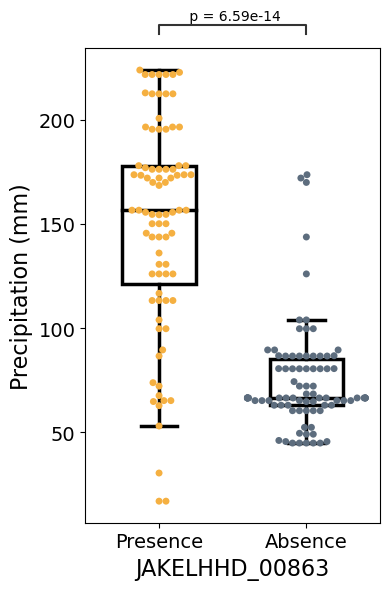

In [78]:
from statannot import add_stat_annotation

# Get top 3 significant results based on 'FDR_Corrected_P_Value'
top_3_results = fdr_adjusted_env_pval_sorted.head(3)

# Visualize top 3 significant results using boxplots with swarm plots
for index, row in top_3_results.iterrows():
    gene = row['Gene']
    env_var = row['Env_var']
    p_value = row['FDR_Corrected_P_Value']  # Get the corrected p-value
    
    plt.figure(figsize=(4, 6))

    # Create a single plot area for both box plot and swarm plot
    fig, ax = plt.subplots(figsize=(4, 6))

    # Filter data for the current gene and environmental variable
    filtered_data = merged_df[[gene, env_var]]

    # Convert gene presence to string for better plotting
    filtered_data.loc[:, gene] = filtered_data[gene].map({0: 'Absence', 1: 'Presence'})

    # Define boxplot properties
    boxplot_kwargs = {
        'boxprops': {'edgecolor': 'k', 'linewidth': 2.5, 'facecolor': 'white'},
        'medianprops': {'color': 'k', 'linewidth': 2.5},
        'whiskerprops': {'color': 'k', 'linewidth': 2.5},
        'capprops': {'color': 'k', 'linewidth': 2.5},
        'width': 0.5
    }

    # Create boxplot with specified order
    sns.boxplot(data=filtered_data, x=gene, y=env_var, ax=ax, showfliers=False, order=['Presence', 'Absence'], **boxplot_kwargs)
    
    # Create swarmplot with specified order
    sns.swarmplot(data=filtered_data, x=gene, y=env_var, ax=ax, palette={'Absence': '#5D6D7E', 'Presence': '#F5B041'}, order=['Presence', 'Absence'])

    # Annotate the plot with the p-value
    box_pairs = [("Presence", "Absence")]
    add_stat_annotation(ax, data=filtered_data, x=gene, y=env_var, order=['Presence', 'Absence'], box_pairs=box_pairs,
                        perform_stat_test=False, text_format='full', loc='outside', verbose=2,
                        pvalue_format_string="{:.2e}", pvalues=[p_value], comparisons_correction=None)

    # Set plot title and labels
    plt.xlabel(f'{gene}', size=16)
    plt.ylabel(env_var, size=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Replace invalid characters in the title
    safe_title = f'{gene}_vs_{env_var}'.replace('/', '_').replace('\\', '_') 

    # Save the plot with the respective title
    plt.tight_layout()
    plt.savefig(out_path_2 + f'{safe_title}.pdf', format='pdf', dpi=600)
    plt.show()

In [79]:
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot.rename(columns={' Predicted protein name': 'Predicted protein name'}, inplace=True)
gen_annot.rename(columns={' eggNOG free text description': 'eggNOG description'}, inplace=True)
gen_annot = gen_annot[['query_name', 'Predicted protein name', 'COG Functional Category', 'eggNOG description']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# gene name and function of the top 3 genes
top_3_abio = ['HLGJJJBE_01458', 'EMHFBLLB_00624', 'JAKELHHD_00863']

# Select the rows where 'query_name' is in the list
top_3_abio_annot = gen_annot[gen_annot['query_name'].isin(top_3_abio)]
top_3_abio_annot

,query_name,Predicted protein name,COG Functional Category,eggNOG description
4922,EMHFBLLB_00624,gatA,J,catalyzes the hydrolysis of a monocarboxylic a...
8056,HLGJJJBE_01458,0,S,Leucine-rich repeat (LRR) protein
9066,JAKELHHD_00863,gatA,J,catalyzes the hydrolysis of a monocarboxylic a...


#### Fig. 2f Enrichment of COG functions among abiotic-linked lineage genes

In [80]:
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)

gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

In [81]:
# Convert 'COG Functional Category' column to lists of individual characters
gen_env_annotated['COG Functional Category'] = gen_env_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_env_list = [char for sublist in gen_env_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_env_series = pd.Series(cog_env_list)

In [82]:
# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_env_cog = cog_env_series.value_counts(normalize=False).to_frame(name='Count')

In [83]:
# Perform the enrichment analysis
sig_env_cog_enrich = enrichment_analysis(count_sig_env_cog, prop_exp)

In [84]:
# Prepare the dataframe for bubble plot visualization
sig_env_cog_enrich_count = pd.merge(sig_env_cog_enrich, count_sig_env_cog, left_index = True, right_index = True)
sig_env_cog_enrich_count = sig_env_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_env_cog_enrich_count = sig_env_cog_enrich_count[sig_env_cog_enrich_count['COG functional category'] != 'S']

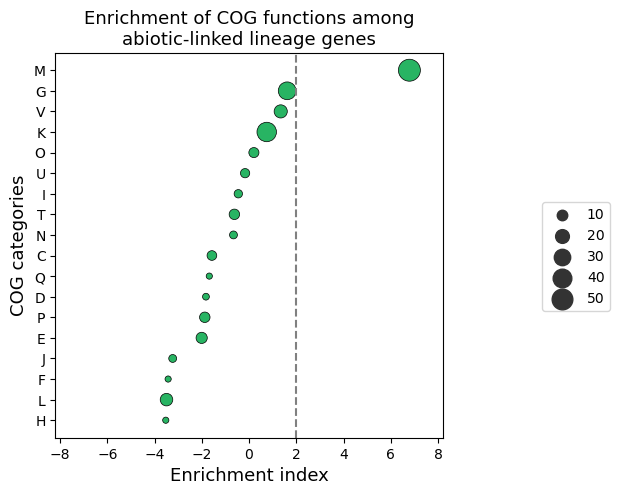

In [85]:
# Make a bubble plot

plt.rcParams["figure.figsize"] = (5, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_env_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#28B463',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COG functions among\nabiotic-linked lineage genes', size = 13)
plt.xlabel('Enrichment index', size = 13)
plt.ylabel('COG categories', size = 13)
plt.legend(bbox_to_anchor=(1.45, 0.63))
plt.xlim(-8.2,8.2)

plt.savefig(out_path_2 + 'fig_2f_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Taxonomic data processing

In [86]:
def data_cleaner(count_data, sep):
  def extract_new_name(col_name, sep, unknown_counter=None):
    # Splitting the string at 'p__'
    if col_name == "index":
        return col_name
    parts = col_name.split(sep)
    if len(parts) > 1:
        # Further splitting at ';' and taking the first part
        new_name = parts[1].split(';')[0]
        if len(new_name) <= 1:
            new_name = 'Unknown'
    else:
        new_name = 'Unknown'
    # Ensuring uniqueness for 'Unknown' columns
    if new_name == 'Unknown' and unknown_counter is not None:
        new_name += f"_{unknown_counter[0]}"
        unknown_counter[0] += 1
    return new_name

  # Initialize a counter for 'Unknown' names
  unknown_counter = [1]

  # Renaming the columns with a unique identifier for 'Unknown'
  new_column_names = {col: extract_new_name(col, sep, unknown_counter=unknown_counter) for col in count_data.columns}

  count_data_cleaned = count_data.rename(columns=new_column_names)


  # Identify all 'Unknown' columns
  unknown_columns = [col for col in count_data_cleaned.columns if 'Unknown' in col]


  # sum unknown columns into a new column
  if unknown_columns:
      count_data_cleaned['Unknown'] = count_data_cleaned[unknown_columns].sum(axis=1)

  count_data_cleaned = count_data_cleaned.drop(columns=unknown_columns)

  # Calculate the sum of each column
  row_sums = count_data_cleaned.iloc[:, 1:].sum(axis=1)

  # Divide each entry of each column by the respective row sum
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)



  count_data_cleaned.drop('Unknown', axis=1, inplace=True, errors='ignore')

  return count_data_cleaned

In [87]:
def plot_2_box_mw(
    data, x, y, group1, group2, title="", out_path="", file_title="", figsize=(4, 6), boxplot_kwargs=None
):
    """
    Plots a combined box plot with statistical annotations and Mann-Whitney U test.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): The name of the column in 'data' to be used as x-axis groups.
    - y (str): The name of the column in 'data' for the y-axis values.
    - group1 (str): The name of the first group to compare.
    - group2 (str): The name of the second group to compare.
    - title (str): Title of the plot.
    - out_path (str): Output path for saving the plot.
    - file_title (str): File title for saving the plot.
    - figsize (tuple): Size of the figure.
    - boxplot_kwargs (dict): Additional keyword arguments for the box plot.
    """

    if boxplot_kwargs is None:
        boxplot_kwargs = {
            "boxprops": {"edgecolor": "k", "linewidth": 2.5},
            "medianprops": {"color": "k", "linewidth": 2.5},
            "whiskerprops": {"color": "k", "linewidth": 2.5},
            "capprops": {"color": "k", "linewidth": 2.5},
            "width": 0.5,
        }
    boxplot_order = [group1, group2]
    plt.rcParams["figure.figsize"] = figsize

    # Adjusting the palette to apply colors to the boxes
    colors = ["#EC7063", "#636669"]

    # Create a single plot area for both box plot
    fig, ax = plt.subplots()

    sns.boxplot(
        data=data,
        x=x,
        y=y,
        order=boxplot_order,
        palette=dict(zip(boxplot_order, colors)),
        ax=ax,
        **boxplot_kwargs,
        showfliers=False,
    )

    test_results = add_stat_annotation(
        ax,
        data=data,
        x=x,
        y=y,
        box_pairs=[(group1, group2)],
        test="Mann-Whitney",
        text_format="full",
        loc="outside",
        verbose=2,
        pvalue_format_string="{:.2g}",
    )

    plt.xticks(size=15)
    plt.ylabel(y, size=15)
    plt.xlabel("")

    # Generate a safe file title
    safe_file_title = file_title.replace("/", "_").replace("\\", "_")

    plt.tight_layout() 
    plt.savefig(f"{out_path}/{safe_file_title}.pdf", format="pdf", dpi=300)
    plt.show()


In [88]:
def MW_test(isolate, env, plot_title, out_path):
    """
    Performs Mann-Whitney U tests and generates plots based on the results.

    Parameters:
    - isolate (DataFrame): DataFrame containing isolate information.
    - env (DataFrame): DataFrame containing environmental data.
    - plot_title (str): Title for the volcano plot.
    - out_path (str): Output path for saving the plots.
    """
    # Assign groups for samples positive for LM and negative for LM
    monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
    LM = monocytogenes_isolate[(monocytogenes_isolate['Phylogroup'] == 'III') |
                               (monocytogenes_isolate['Phylogroup'] == 'II') |
                               (monocytogenes_isolate['Phylogroup'] == 'I')]

    sample = env.copy()
    sample['group'] = np.where(sample.index.isin(LM['Sample ID']), 'With LM', 'Without LM')
    group = sample[['group']]

    LM_pos = group[group['group'] == 'With LM']
    LM_neg = group[group['group'] == 'Without LM']

    # Perform MW tests
    pval = defaultdict(list)
    for columnName, columnData in env.items():
        pos = columnData[columnData.index.isin(LM_pos.index)]
        neg = columnData[columnData.index.isin(LM_neg.index)]
        u, prob = mannwhitneyu(pos, neg, alternative='two-sided')
        pval[columnName].append(prob)

    sig_env = fdr_sig(pval)
    fdr_env = fdr(pval)

    n_sig_env = len(sig_env)
    print("Number of significant variables: ", n_sig_env)
    for key, value in sig_env.items():
        print(f'{key}: {value}')

    if n_sig_env <= 10:
        for key, val in sig_env.items():
            prep_gp = pd.merge(env[[key]], group, left_index=True, right_index=True)
            plot_2_box_mw(data=prep_gp, x='group', y=key, group1='With LM', group2='Without LM',
                          title=key, figsize=(4, 6), out_path=out_path)
    else:
        volcano_df = pd.DataFrame(columns=['log2 (fold change)', '-log10 (adjusted p)'])
        for key, val in fdr_env.items():
            # Merge environmental data with group data for this variable
            prep_gp = pd.merge(env[[key]], group, left_index=True, right_index=True)
            # Calculate mean values for positive and negative groups
            mean_pos = prep_gp[prep_gp['group'] == 'With LM'][key].mean()
            mean_neg = prep_gp[prep_gp['group'] == 'Without LM'][key].mean()
            # Calculate mean difference
            mean_diff = np.log2(mean_pos / mean_neg)
            # Calculate -log10(p-value)
            neg_log_pval = -np.log10(val)
            # Append the results to the volcano_df DataFrame
            volcano_df.loc[key] = [mean_diff, neg_log_pval]

        plot_volcano_with_stats(volcano_df, 'log2 (fold change)', '-log10 (adjusted p)',
                                sig_data=sig_env, title=plot_title, out_path=out_path)

### Supplementary Fig. 5 | OTUs that are significantly different among Lm lineages 

In [89]:
def plot_heatmap_mean_log(mean_data, title="", figsize=(6, 6), out_path=""):
    """
    Plots a heatmap of log-transformed mean values for the three classes (L1, L2, L3) based on significant variables.

    Parameters:
    - mean_data (DataFrame): The DataFrame containing mean values for each variable and class.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    - out_path (str): Path to save the plot. Default is an empty string (current directory).
    """

    # Take the logarithm of the data
    log_mean_data = np.log(mean_data)

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(log_mean_data, cmap='coolwarm', annot=False, linewidths=0.5)
    plt.xlabel('Lineage')
    plt.ylabel('Variables')
    plt.title(title)

    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('log(relative abundance)')

    # Add this line to fit the plot
    plt.tight_layout()
    
    # Save the plot if out_path is provided
    if out_path:
        plt.savefig(out_path + f'{title}.pdf', format='pdf', dpi=300)
    plt.show()

In [90]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap_mean_log_annot(mean_data, significance_df, title="", figsize=(6, 6), out_path=""):
    """
    Plots a heatmap of log-transformed mean values for the three classes (L1, L2, L3) based on significant variables
    and annotates cells with significance labels using alphabets (e.g., 'a', 'b', 'c').

    Parameters:
    - mean_data (DataFrame): The DataFrame containing mean values for each variable and class.
    - significance_df (DataFrame): The DataFrame containing significance annotations for each variable and class.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    - out_path (str): Path to save the plot. Default is an empty string (current directory).
    """

    # Update the column names to match those in heatmap_df
    numeric_columns = ['I', 'II', 'III']
    annotation_columns = ['I_y', 'II_y', 'III_y']

    # Log-transform only numeric columns
    log_mean_data = np.log(mean_data[numeric_columns].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(log_mean_data, cmap='coolwarm', annot=False, linewidths=0.5)
    plt.xlabel('Lineage', size=15)
    plt.ylabel('OTUs', size=15)
    plt.title(title, size=15)

    # Add significance annotations using alphabets
    for i, row in enumerate(log_mean_data.index):
        for j, col in enumerate(log_mean_data.columns):
            # Get the annotation value from the significance DataFrame
            annotation_value = significance_df.at[row, annotation_columns[j]]
            if pd.notna(annotation_value) and annotation_value != '':  # Check if there's a non-empty significance label to add
                ax.text(j + 0.5, i + 0.5, annotation_value,  # Annotate with significance label
                        ha='center', va='center', fontsize=12, color='#000000')

    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('log(relative abundance)')

    # Adjust layout to fit the plot
    plt.tight_layout()

    # Save the plot if out_path is provided
    if out_path:
        plt.savefig(out_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [91]:
# Reading data
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)
otus_data = pd.read_excel(data_path + "rarified_OTU_table-with-taxonomy_processed.xlsx", index_col=0, header=1)
otus_data = otus_data.dropna()

In [92]:
# renaming L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

In [93]:
# Filtering for L. monocytogenes
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
monocytogenes_isolate_L1 = monocytogenes_isolate[(monocytogenes_isolate['Phylogroup'] == 'III')]
monocytogenes_isolate_L2 = monocytogenes_isolate[(monocytogenes_isolate['Phylogroup'] == 'II')]
monocytogenes_isolate_L3 = monocytogenes_isolate[(monocytogenes_isolate['Phylogroup'] == 'I')]

#### Supplementary Fig. 5a Heatmap of the relative abundance of OTUs among Lm lineages

In [94]:
# perform KW tests
from scipy.stats import kruskal

pval = defaultdict(list)

for (columnName, columnData) in otus_data.items():

    # Select data for each group (L1, L2, L3) based on your criteria
    L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
    L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
    L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]

    # Check if all values in the column are identical
    if len(set(L1)) > 1 and len(set(L2)) > 1 and len(set(L3)) > 1:
        # Perform the Kruskal-Wallis test only if there is variation in the column
        u, prob = kruskal(L1, L2, L3)
        pval[columnName].append(prob)
    else:
        # If all values are identical, set p-value to 1.0
        pval[columnName].append(np.float64(1.0))

sig_otu = fdr_sig(pval)
len(sig_otu)

29

In [95]:
from scipy.stats import mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests

def pairwise_mannwhitneyu(data, groups):
    p_values = {}
    group_combinations = combinations(groups, 2)
    
    for group1, group2 in group_combinations:
        try:
            _, p_value = mannwhitneyu(data[group1], data[group2], alternative='two-sided')
            p_values[f"{group1}_{group2}"] = p_value
        except ValueError as e:
            print(f"Error comparing {group1} and {group2}: {e}")
    
    return p_values

def assign_labels(p_values, alpha=0.05):
    groups = sorted(set(group for pair in p_values.keys() for group in pair.split('_')))
    labels = {group: set('a') for group in groups}
    
    def get_p_value(g1, g2):
        pair = f"{g1}_{g2}" if g1 < g2 else f"{g2}_{g1}"
        return p_values.get(pair, 0)
    
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            if get_p_value(group1, group2) < alpha:
                if labels[group1] == labels[group2]:
                    new_label = chr(ord(max(labels[group2])) + 1)
                    labels[group2] = set(new_label)
                    
    for group in groups:
        if all(get_p_value(group, other) >= alpha for other in groups if other != group):
            labels[group] = set(''.join(sorted(set.union(*labels.values()))))
    
    result_labels = {group: ''.join(sorted(label)) for group, label in labels.items()}
    print("Final labels:", result_labels)
    return result_labels

In [96]:
# Reset index on the otu DataFrame so that we can merge based in Sample ID
otus_data_reset = otus_data.reset_index()
otus_data_reset = otus_data_reset.rename(columns={'#OTU ID': 'Sample ID'})

# Filter the isolate DataFrame to keep only rows with 'LM lineage III', 'LM lineage II', 'LM lineage I' in 'Phylogroup'
filtered_isolate = isolate[isolate['Phylogroup'].isin(['III', 'II', 'I'])]

In [97]:
# Assuming 'otus_data' is your DataFrame and it has a 'Sample ID' column
otus_data_2 = pd.merge(otus_data_reset, filtered_isolate, on='Sample ID')

# Dictionary to store pairwise p-values for each column
pairwise_pval = defaultdict(dict)

# Define your combinations
combinations_list = [("LM lineage I", "LM lineage II"),
                     ("LM lineage II", "LM lineage III"),
                     ("LM lineage I", "LM lineage III")]

# Perform pairwise Mann-Whitney tests for each column
for column_name in sig_otu:
    data = otus_data_2.groupby('Phylogroup')[column_name].apply(list).to_dict()
    try:
        pairwise_pval[column_name] = pairwise_mannwhitneyu(data, data.keys())
    except ValueError as e:
        # If an error occurs, print the error
        print(f"Error in column '{column_name}': {e}")

# Apply FDR correction to the p-values
fdr_corrected_pvals = {}
labels_assigned = {}
for column, p_values in pairwise_pval.items():
    pvals = list(p_values.values())
    _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha=0.05)
    pairs_with_p_less_than_0_05 = {pair: pvals_corrected[i] for i, pair in enumerate(p_values.keys())}
    fdr_corrected_pvals[column] = pairs_with_p_less_than_0_05
    labels_assigned[column] = assign_labels(pairs_with_p_less_than_0_05)

# Convert the dictionary into a dataframe
assigned = pd.DataFrame(labels_assigned)

# Transpose row and column
assigned = assigned.transpose()

Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'c'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'c'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'ab', 'II': 'a', 'III': 'b'}
Final labels: {'I': 'a', 'II': 'b', 'III': 'a'}
Final labels: {'I': 'a', 'II': 'b

In [98]:
heatmap_df = pd.DataFrame(columns=['I', 'II', 'III'])
i =0
for key, val in sig_otu.items():
    prep_gp = pd.merge(otus_data_reset, filtered_isolate, on='Sample ID')
    prep_gp = prep_gp[[f"{key}", 'Phylogroup']]

    # Calculate mean values for positive and negative groups
    mean_L1 = prep_gp[prep_gp['Phylogroup'] == 'III'][key].mean()
    mean_L2 = prep_gp[prep_gp['Phylogroup'] == 'II'][key].mean()
    mean_L3 = prep_gp[prep_gp['Phylogroup'] == 'I'][key].mean()

    # Append the results to the heatmap_df DataFrame
    heatmap_df.loc[key] = [mean_L3, mean_L2, mean_L1]

In [99]:
# Merge assigned_annotation with heatmap_df
heatmap_df = heatmap_df.merge(assigned, how='left', left_index=True, right_index=True)

# Iterate over rows in the DataFrame to get rid of cases where there are the same letters - significant in KW but not pairwise MW
for index, row in heatmap_df.iterrows():
    # Check if the values in 'LM lineage I', 'LM lineage II', and 'LM lineage III' columns are the same
    if row['I_y'] == row['II_y'] == row['III_y']:
        # If they are the same, replace the values with ''
        heatmap_df.at[index, 'I_y'] = ''
        heatmap_df.at[index, 'II_y'] = ''
        heatmap_df.at[index, 'III_y'] = ''

# Rename columns in heatmap_df
heatmap_df = heatmap_df.rename(columns={'I_x': 'I', 'II_x': 'II', 'III_x': 'III'})

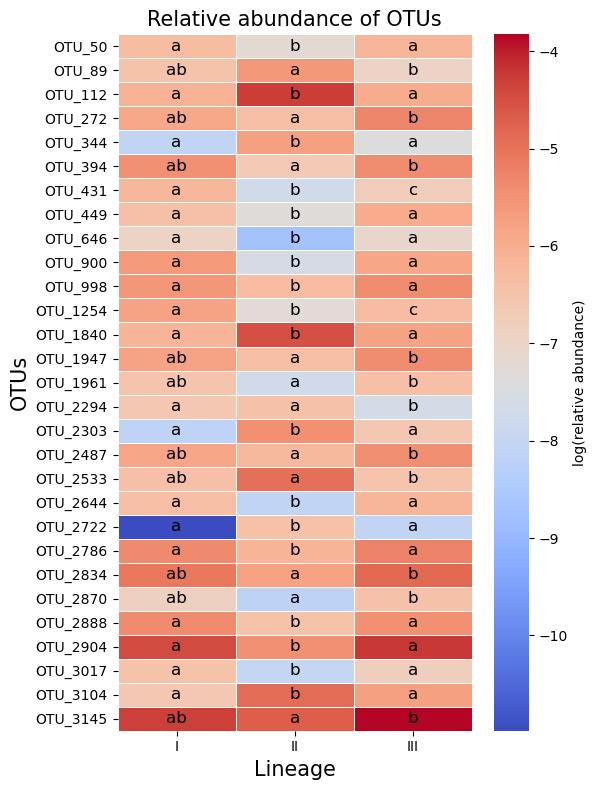

In [100]:
plot_heatmap_mean_log_annot(mean_data=heatmap_df[['I', 'II', 'III']],
    significance_df=heatmap_df[['I_y', 'II_y', 'III_y']],
    title="Relative abundance of OTUs",
    figsize=(6, 8),
    out_path=out_path_3 + 'fig_s5a_heatmap_mean_log_otu_annot.pdf'
)

#### Supplementary Fig. 5b Bacterial taxonomic composition of the 29 OTUs

In [ ]:
# Load input data
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
gen_pre_abs = gen_pre_abs.transpose()
gen_pre_abs = gen_pre_abs.rename_axis('Isolate ID')

# Reset index and find the sample ID for the isolates
lm_sample = lm_isolate.reset_index()
lm_sample = lm_sample[['Isolate ID', 'Sample ID']]

# Load OTU data
otus_data = pd.read_excel(data_path + "rarified_OTU_table-with-taxonomy_processed.xlsx", index_col=0, header=1)
otus_data = otus_data.dropna()

# Merge with lm_sample
otu_isolate = lm_sample.merge(otus_data, left_on='Sample ID', right_index=True, how='left', suffixes=('', '_otu'))

# Set 'Isolate ID' as the index and drop 'Sample ID' column
otu_isolate.set_index('Isolate ID', inplace=True)
otu_isolate.drop(columns=['Sample ID'], inplace=True)

# Drop rows with NaN values
otu_isolate = otu_isolate.dropna()

# Drop rows not present in either gen_pre_abs or env_isolate
common_index = gen_pre_abs.index.intersection(otu_isolate.index)
gen_pre_abs_otu = gen_pre_abs.loc[common_index]
otu_isolate = otu_isolate.loc[common_index]

# Drop columns that consist only zeros in 'gen_pre_abs_otu' df
column_totals = gen_pre_abs_otu.sum(axis=0)
columns_with_zero_total = column_totals[column_totals == 0].index
gen_pre_abs_otu = gen_pre_abs_otu.drop(columns=columns_with_zero_total)

# Drop columns that consist all 'one' in 'gen_pre_abs_otu' df - core gene
column_totals_175 = gen_pre_abs_otu.sum(axis=0)
columns_with_175_total = column_totals_175[column_totals_175 == 175].index
gen_pre_abs_otu_accessory = gen_pre_abs_otu.drop(columns=columns_with_175_total)

# Merge the two dataframes based on the index of gen_pre_abs_otu
merged_df = gen_pre_abs_otu.merge(otu_isolate, left_index=True, right_index=True)

# Remove title for index
otu_isolate.index.name = None
otu_isolate.columns.name = None
gen_pre_abs_otu.index.name = None
gen_pre_abs_otu.columns.name = None

# Export DataFrame to CSV
gen_pre_abs_otu_accessory.to_csv(data_path_lm + 'gen_pre_abs_otu.csv', index=True)
otu_isolate.to_csv(data_path_lm + 'otu_isolate.csv', index=True)

print(len(gen_pre_abs_otu.columns))
print(len(gen_pre_abs_otu_accessory.columns))

In [ ]:
# Convert sig_gene to a list of keys if it is a dictionary
if isinstance(sig_gene, dict):
    sig_gene = list(sig_gene.keys())

# Loading input files
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)
sig_gen_pre_abs = gen_pre_abs.loc[sig_gene]
sig_gen_pre_abs = sig_gen_pre_abs.transpose()
sig_gen_pre_abs = sig_gen_pre_abs.rename_axis('Isolate ID')

lm_sample = lm_isolate.reset_index()
lm_sample = lm_sample[['Isolate ID', 'Sample ID']]

if isinstance(sig_otu, dict):
    sig_otu = list(sig_otu.keys())

# Selecting sig_otu variable from otu_isolate
sig_otu_isolate = otu_isolate[otu_isolate.columns.intersection(sig_otu)]
    
# Drop rows not present in either gen_pre_abs or sig_env_isolate
common_index = sig_gen_pre_abs.index.intersection(sig_otu_isolate.index)
sig_gen_pre_abs = sig_gen_pre_abs.loc[common_index]
sig_otu_isolate = sig_otu_isolate.loc[common_index]

In [ ]:
sig_gen_pre_abs.shape

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Initialize an empty DataFrame to store the raw p-values
raw_pval = pd.DataFrame()

# Initialize an empty DataFrame to store significant results after FDR correction
fdr_corrected_results = pd.DataFrame()

# Iterate through each gene in sig_gen_pre_abs
for gene in sig_gen_pre_abs.columns:
    # Get the rows where the gene is present (1) and absent (0)
    present_rows = sig_gen_pre_abs[sig_gen_pre_abs[gene] == 1].index
    absent_rows = sig_gen_pre_abs[sig_gen_pre_abs[gene] == 0].index
    
    # Initialize lists to store Mann-Whitney test results
    u_values = []
    p_values = []
    
    # Iterate through each OTU in sig_otu_isolate
    for otu in sig_otu_isolate.columns:
        # Get the environmental values for the present and absent groups
        present_otu = sig_otu_isolate.loc[present_rows, otu]
        absent_otu = sig_otu_isolate.loc[absent_rows, otu]
        
        # Perform Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(present_otu, absent_otu)
        
        # Append the results to the lists
        u_values.append(u_statistic)
        p_values.append(p_value)
    
    # Create a DataFrame to store the Mann-Whitney test results for each OTU
    mw_results = pd.DataFrame({
        'Gene': gene,
        'OTU': sig_otu_isolate.columns,
        'U_Value': u_values,
        'P_Value': p_values
    })
    
    # Concatenate the raw p-values results
    raw_pval = pd.concat([raw_pval, mw_results])

# Perform False Discovery Rate (FDR) correction on the combined p-values
rejected, p_corrected, _, _ = multipletests(raw_pval['P_Value'], alpha=0.05, method='fdr_bh')

# Add the FDR-corrected p-values to the raw_pval_results DataFrame
raw_pval['FDR_Corrected_P_Value'] = p_corrected
raw_pval['Rejected'] = rejected

# Filter for significant results after FDR correction
fdr_adjusted_pval = raw_pval[raw_pval['Rejected']]

# Select columns for the FDR corrected results
fdr_adjusted_otu_pval = fdr_adjusted_pval[['Gene', 'OTU', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]
gen_otu = fdr_adjusted_otu_pval.copy()

# Reorder the raw_pval_results columns as per your requirement
raw_otu_pval = raw_pval[['Gene', 'OTU', 'U_Value', 'P_Value', 'FDR_Corrected_P_Value']]

In [ ]:
# Load taxonomic annotation file for the OTUs
otu_taxon = pd.read_csv(data_path + 'OTU_taxon.csv', index_col=0)

# Get the unique values from the 'OTU' column
unique_otus = gen_otu['OTU'].unique()

# Convert the unique values into a DataFrame with 'query_name' as the column name
otu_df = pd.DataFrame(unique_otus, columns=['OTUs'])

# Set 'query_name' as the index of the DataFrame
otu_df.set_index('OTUs', inplace=True)

# Merge otu_df with otu_taxon using the 'query_name' index from otu_df
otu_taxon_annot = otu_df.merge(otu_taxon, left_index=True, right_on='OTUs', how='left')

# Categorize unique names with only one instance as 'Others'
for col in otu_taxon_annot.columns:
    value_counts = otu_taxon_annot[col].value_counts()
    single_instance_names = value_counts[value_counts == 1].index
    otu_taxon_annot[col] = otu_taxon_annot[col].apply(lambda x: 'Others' if x in single_instance_names else x)

# Prepare data for stacked bar chart using percentages
stacked_data = otu_taxon_annot.apply(lambda x: x.value_counts(normalize=True)).fillna(0) * 100

# Transpose the DataFrame for plotting
stacked_data = stacked_data.T

# Sort columns so that the highest percentage starts from the bottom
stacked_data = stacked_data[stacked_data.sum().sort_values(ascending=False).index]

# Reorder index to start with 'Species' from the bottom
taxonomic_levels = ['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum']
stacked_data = stacked_data.reindex(taxonomic_levels)

# Plot a horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

colors = plt.cm.tab20(range(len(stacked_data.columns)))

stacked_data.plot(kind='barh', stacked=True, ax=ax, color=colors)

# Set labels and title
ax.set_xlabel('Percentage (%)')
ax.set_title('Taxonomic classification of OTUs significantly differing among Lm lineages')
ax.set_yticklabels(stacked_data.index)

# Create a legend dictionary for all taxonomic levels
legend_dict = {}
color_mapping = {col: colors[i] for i, col in enumerate(stacked_data.columns)}

for level in taxonomic_levels:
    handles = []
    labels = []
    for col in stacked_data.columns:
        if stacked_data.loc[level, col] > 0:
            handles.append(plt.Rectangle((0, 0), 1, 1, color=color_mapping[col]))
            labels.append(col)
    legend_dict[level] = (handles, labels)

# Adjust the positioning of the legend for all taxonomic levels
legend_positions = {
    'Phylum': (1, 0.95),
    'Class': (1, 0.68),
    'Order': (1, 0.37),
    'Family': (1.21, 0.95),
    'Genus': (1.21, 0.68),
    'Species': (1.21, 0.54)
}

# Display the legend for all taxonomic levels
for level, (handles, labels) in legend_dict.items():
    fig.legend(handles=handles, 
               labels=labels, 
               title=level,
               bbox_to_anchor=legend_positions[level],
               loc='upper left',
               frameon=False)

# Hide the original legend
ax.legend().set_visible(False)

plt.tight_layout()

plt.savefig(out_path_3 + 'fig_s5b_otu_taxon.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Supplementary Fig. 6 | Relative abundance of bacterial phyla among Lm lineages

In [ ]:
# Function for FDR correction

def fdr(p_value):
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key][0])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    fdr = {}
    for c_key in p_value:
        fdr[c_key] = p_corr[n_p]
        n_p = n_p + 1
    return fdr

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from collections import defaultdict

def KW_test(isolate, env, plot_title, out_path):
    """
    Performs Kruskal-Wallis tests, applies FDR correction, performs pairwise Mann-Whitney U tests with FDR correction,
    assigns labels to corrected p-values, and generates plots based on the results. Exports DataFrame of corrected
    pairwise p-values with labels appended.

    Parameters:
    - isolate (DataFrame): DataFrame containing isolate information.
    - env (DataFrame): DataFrame containing environmental data.
    - plot_title (str): Title for the plots.
    - out_path (str): Output path for saving the plots.

    Returns:
    - pairwise_pvals_corrected_df (DataFrame): DataFrame containing FDR-corrected pairwise Mann-Whitney U test p-values 
      and their labels for significant variables.
    """
    # Assign groups for samples positive for LM and negative for LM
    monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
    monocytogenes_isolate_L1 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'III']
    monocytogenes_isolate_L2 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'II']
    monocytogenes_isolate_L3 = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'] == 'I']

    # Perform KW tests
    pval = defaultdict(list)
    for columnName, columnData in env.items():
        L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
        L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
        L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]

        # Check if all values in the column are identical
        if len(set(L1)) > 1 and len(set(L2)) > 1 and len(set(L3)) > 1:
            # Perform the Kruskal-Wallis test only if there is variation in the column
            u, prob = kruskal(L1, L2, L3)
            pval[columnName].append(prob)
        else:
            # If all values are identical, set p-value to 1.0
            pval[columnName].append(np.float64(1.0))

    # Apply FDR correction to identify significant variables
    sig_env = fdr_sig(pval)
    n_sig_env = len(sig_env)

    print("Number of significant variables: ", n_sig_env)
    for key, value in sig_env.items():
        print(f'{key}: {value}')

    # Reset index on the env DataFrame so that we can merge based on Sample ID
    env_reset = env.reset_index()
    env_reset = env_reset.rename(columns={'index': 'Sample ID'})

    # Filter the isolate DataFrame to keep only rows with 'LM lineage III', 'LM lineage II', 'LM lineage I' in 'Phylogroup'
    filtered_isolate = isolate[isolate['Phylogroup'].isin(['III', 'II', 'I'])]

    heatmap_df = pd.DataFrame(columns=['I', 'II', 'III'])  # Initialize an empty DataFrame for heatmap
    pairwise_pvals = {}  # Initialize a dictionary to store pairwise Mann-Whitney U test results

    for key, val in sig_env.items():
        prep_gp = pd.merge(env_reset, filtered_isolate, on='Sample ID')
        prep_gp = prep_gp[[f"{key}", 'Phylogroup']]

        if n_sig_env > 10:
            # Calculate mean values for positive and negative groups and append to heatmap_df
            mean_L1 = prep_gp[prep_gp['Phylogroup'] == 'III'][key].mean()
            mean_L2 = prep_gp[prep_gp['Phylogroup'] == 'II'][key].mean()
            mean_L3 = prep_gp[prep_gp['Phylogroup'] == 'I'][key].mean()

            heatmap_df.loc[key] = [mean_L1, mean_L2, mean_L3]

        # Perform pairwise Mann-Whitney U tests
        L1_vals = prep_gp[prep_gp['Phylogroup'] == 'III'][key]
        L2_vals = prep_gp[prep_gp['Phylogroup'] == 'II'][key]
        L3_vals = prep_gp[prep_gp['Phylogroup'] == 'I'][key]

        # Initialize dictionary to store pairwise p-values for the current variable
        pairwise_pvals[key] = pairwise_mannwhitneyu({'III': L1_vals, 'II': L2_vals, 'I': L3_vals}, ['I', 'II', 'III'])

    # Apply FDR correction for each row's pairwise p-values
    pairwise_pvals_corrected = {}
    for column, p_values in pairwise_pvals.items():
        pvals = list(p_values.values())

        # Apply FDR correction
        _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha=0.05)

        # Store corrected p-values
        pairs_with_p_less_than_0_05 = {pair: pvals_corrected[i] for i, pair in enumerate(p_values.keys())}
        pairwise_pvals_corrected[column] = pairs_with_p_less_than_0_05

    # Convert the corrected pairwise p-values to DataFrame
    pairwise_pvals_corrected_df = pd.DataFrame.from_dict(pairwise_pvals_corrected, orient='index')

    # Assign labels to the corrected pairwise p-values
    labels_assigned = {}
    for column, p_values in pairwise_pvals_corrected.items():
        labels_assigned[column] = assign_labels(p_values)

    # Convert labels to DataFrame and transpose
    assigned_df = pd.DataFrame(labels_assigned).transpose()

    # Rename columns in pairwise_pvals_corrected_df
    assigned_df = assigned_df.rename(columns={'I': 'I_y', 'II': 'II_y', 'III': 'III_y'})

    # Merge assigned_annotation with heatmap_df
    heatmap_df = heatmap_df.merge(assigned_df, how='left', left_index=True, right_index=True)

    # Iterate over rows in the DataFrame to get rid of cases where there are the same letters - significant in KW but not pairwise MW
    for index, row in heatmap_df.iterrows():
        if row['I_y'] == row['II_y'] == row['III_y']:
            heatmap_df.at[index, 'I_y'] = ''
            heatmap_df.at[index, 'II_y'] = ''
            heatmap_df.at[index, 'III_y'] = ''

    # Export heatmap with annotations
    if n_sig_env > 10:
        plot_heatmap_mean_log_annot(heatmap_df, assigned_df, plot_title, out_path=out_path)
    else:
        # Plot boxplots for variables with fewer significant results
        for key, val in sig_env.items():
            prep_gp = pd.merge(env_reset, filtered_isolate, on='Sample ID')
            prep_gp = prep_gp[[f"{key}", 'Phylogroup']]
            plot_3_box_with_mw_and_swarm(data=prep_gp, x='Phylogroup', y=f"{key}",
                                         box_pairs=[('I', 'II'), ('I', 'III'), ('II', 'III')],
                                         title=f"{key}", out_path=out_path)

    return pd.concat([pairwise_pvals_corrected_df, assigned_df], axis=1)

In [ ]:
isolate = pd.read_csv(data_path + "Listeria_genomes.csv", index_col=0)

rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

phylum_count_data = pd.read_csv(data_path + "phylum_count.csv")
phylum_count_data_cleaned = data_cleaner(phylum_count_data, sep = "p__")
phylum_count_data_cleaned.set_index('index', inplace=True)
phylum_count_data_cleaned = phylum_count_data_cleaned.dropna()

In [ ]:
KW_test(isolate, phylum_count_data_cleaned, "Phylum relative abundance in samples pos for L1 vs L2 vs L3", out_path=out_path_supp)

### Supplementary Fig. 7 | Relative abundance of taxa at other taxonomic ranks

#### Supplementary Fig. 7a | Relative abundance of class among Lm lineages.

In [ ]:
class_count_data = pd.read_csv(data_path + "class_count.csv")
class_count_data_cleaned = data_cleaner(class_count_data, sep = "c__")
class_count_data_cleaned.set_index('index', inplace=True)
class_count_data_cleaned = class_count_data_cleaned.dropna()

In [ ]:
KW_test(isolate, class_count_data_cleaned, "Class", out_path=out_path_supp + "fig_s5a_class.pdf")

#### Supplementary Fig. 7b | Relative abundance of order among Lm lineages.

In [ ]:
order_count_data = pd.read_csv(data_path + "order_count.csv")
order_count_data_cleaned = data_cleaner(order_count_data, sep = "o__")
order_count_data_cleaned.set_index('index', inplace=True)
order_count_data_cleaned = order_count_data_cleaned.dropna()

In [ ]:
KW_test(isolate, order_count_data_cleaned, "Order", out_path=out_path_supp + "fig_s5b_order.pdf")

#### Supplementary Fig. 7c | Relative abundance of family among Lm lineages.

In [ ]:
family_count_data = pd.read_csv(data_path + "family_count.csv")
family_count_data_cleaned = data_cleaner(family_count_data, sep = "f__")
family_count_data_cleaned.set_index('index', inplace=True)
family_count_data_cleaned = family_count_data_cleaned.dropna()

In [ ]:
KW_test(isolate, family_count_data_cleaned, "Family", out_path=out_path_supp + "fig_s5c_family.pdf")

#### Supplementary Fig. 7d | Relative abundance of genus among Lm lineages.

In [ ]:
genus_count_data = pd.read_csv(data_path + "genus_count.csv")
genus_count_data_cleaned = data_cleaner(genus_count_data, sep = "g__")
genus_count_data_cleaned.set_index('index', inplace=True)
genus_count_data_cleaned = genus_count_data_cleaned.dropna()

In [ ]:
KW_test(isolate, genus_count_data_cleaned, "Genus relative abundance in samples pos for L1 vs L2 vs L3", out_path=out_path_3)

### Supplementary Fig. 8 | MDS of bacterial community compositions among Lm lineages

#### Supplementary Fig. 8a UniFrac distance

In [ ]:
# Filtering for Samples with only one Phylogroup
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
filtered_isolate = monocytogenes_isolate.groupby('Sample ID').filter(lambda x: x['Phylogroup'].nunique() == 1)
filtered_isolate = filtered_isolate.drop_duplicates(subset='Sample ID')

# Reset the current index and keep it as a column
filtered_isolate = filtered_isolate.reset_index()

# Set 'Sample ID' as the new index
filtered_isolate = filtered_isolate.set_index('Sample ID')

#Filtering for monocytogenes
monocytogenes_isolate = filtered_isolate[filtered_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

sample = otus_data.copy()
merged_df_2 = pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)
group = merged_df_2[['Phylogroup']].copy()
group.rename(columns={'Phylogroup': 'group'}, inplace=True)
group.groupby('group').size()

In [ ]:
# MDS using weighted UniFrac distance
weighted_unifrac_dist = pd.read_csv(data_path + "OTU_weighted_unifrac_distance_matrix.tsv", sep='\t')

# Filter rows 
filtered_weighted_unifrac_dist = weighted_unifrac_dist[weighted_unifrac_dist['Unnamed: 0'].isin(group.index)]
filtered_weighted_unifrac_dist = filtered_weighted_unifrac_dist[['Unnamed: 0'] + [col for col in filtered_weighted_unifrac_dist.columns if col in group.index]]
filtered_weighted_unifrac_dist.shape

In [ ]:
from sklearn.manifold import MDS

# Compute the distance matrix
distance_matrix = filtered_weighted_unifrac_dist.drop(columns=['Unnamed: 0']).to_numpy()

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

# Classify samples into groups based on presence of Lm lineages
mds_2d_df = pd.DataFrame(mds_coordinates).set_index(filtered_weighted_unifrac_dist['Unnamed: 0'])
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)
#print (mds_group['group'].value_counts())
#mds_group

In [ ]:
# Perform PERMANOVA test on grouping
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib.patches import Ellipse

grouping = list(mds_group['group'])
symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=filtered_weighted_unifrac_dist['Unnamed: 0'])

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

In [ ]:
colors = ['#CD6155', '#5499C7', '#52BE80']
hue_order = ['I', 'II', 'III']

# Create the plot
plt.rcParams["figure.figsize"] = (6, 6)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')
    e.set_label(lineage)

# Setting the plot title and labels
ax.set_title('Weighted UniFrac', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)

# Setting the plot limits
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

# Adding text for PERMANOVA p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)

# Removing default legend
ax.legend_.remove()

# Creating custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='I', markerfacecolor='#CD6155', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='II', markerfacecolor='#5499C7', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='III', markerfacecolor='#52BE80', markersize=10)]

# Adding custom legend outside the plot
plt.legend(handles=legend_elements, loc='upper right', title='Lineage', fontsize=12)

plt.savefig(out_path_3 + 'fig_3b_mds_unifrac_otu.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()

#### Supplementary Fig. 8b Bray-Curtis distance

In [ ]:
# Load Bray-Curtis input
bray_curtis_dist = pd.read_csv(data_path + "OTU_bray_curtis_distance_matrix.tsv", sep='\t')

# Filter rows and columns
filtered_bray_curtis_dist = bray_curtis_dist[bray_curtis_dist['Unnamed: 0'].isin(group.index)]
filtered_bray_curtis_dist = filtered_bray_curtis_dist[['Unnamed: 0'] + [col for col in filtered_bray_curtis_dist.columns if col in group.index]]

In [ ]:
# Compute the distance matrix
distance_matrix = filtered_bray_curtis_dist.drop(columns=['Unnamed: 0']).to_numpy()

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

In [ ]:
# Classify samples into groups based on presence of Lm lineages
mds_2d_df = pd.DataFrame(mds_coordinates).set_index(filtered_bray_curtis_dist['Unnamed: 0'])
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)

In [ ]:
# Perform PERMANOVA test on grouping

grouping = list(mds_group['group'])

symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=filtered_bray_curtis_dist['Unnamed: 0'])

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

# Calculate total variation (SS Total)
total_variation = np.sum(symmetric_distance_matrix.data ** 2) / symmetric_distance_matrix.shape[0]

# Calculate sum of squares between groups (SS Between)
# This can be obtained from the PERMANOVA results or calculated manually
# For example, if permanova_results['test statistic'] is the pseudo-F:
pseudo_F = permanova_results['test statistic']
SS_between = pseudo_F * (len(grouping) - 1)

# Calculate R²
R_squared = SS_between / total_variation

# Print or use the results
#print("Estimated R²:", R_squared)

In [ ]:
colors = ['#CD6155', '#5499C7', '#52BE80']
hue_order = ['I', 'II', 'III']

# Create the plot
plt.rcParams["figure.figsize"] = (6, 6)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')
    e.set_label(lineage)

# Setting the plot title and labels
ax.set_title('Bray-Curtis', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)


# Setting the plot limits
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)


# Adding text for PERMANOVA p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)

# Removing default legend
ax.legend_.remove()

# Creating custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='I', markerfacecolor='#CD6155', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='II', markerfacecolor='#5499C7', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='III', markerfacecolor='#52BE80', markersize=10)]

# Adding custom legend outside the plot
plt.legend(handles=legend_elements, loc='upper right', title='Lineage', fontsize=12)

plt.savefig(out_path_supp + 'fig_s4_mds_braycurtis_otu.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()

### Fig. 3 | Associations between bacterial community composition and the pangenome of Lm

#### Fig. 3a RDA between the accessory genome of Lm and surrounding bacterial communities

In [ ]:
# Feature selection for OTU to be included in RDA using L1 regularization (Lasso)
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale data using RobustScaler - account for outliers, more robust
scaler = RobustScaler()
X = scaler.fit_transform(otu_isolate)

# Perform L1 regularization (Lasso)
lasso = Lasso(alpha=0.1, max_iter=10000, tol=1e-3)
lasso_selector = lasso.fit(X, gen_pre_abs_otu_accessory.sum(axis=1)) # Using gene richness as a proxy target
lasso_support = lasso_selector.coef_ != 0
lasso_features = otu_isolate.columns[lasso_support]
#print("Lasso selected features:", lasso_features)

# Create a new dataframe with selected features
selected_otu = otu_isolate[list(lasso_features)]
print(len(otu_isolate.columns))
print(len(selected_otu.columns))

In [ ]:
# perform KW tests
from scipy.stats import kruskal

pval = defaultdict(list)

for (columnName, columnData) in otus_data.items():

    # Select data for each group (L1, L2, L3) based on your criteria
    L1 = columnData[columnData.index.isin(monocytogenes_isolate_L1["Sample ID"])]
    L2 = columnData[columnData.index.isin(monocytogenes_isolate_L2["Sample ID"])]
    L3 = columnData[columnData.index.isin(monocytogenes_isolate_L3["Sample ID"])]

    # Check if all values in the column are identical
    if len(set(L1)) > 1 and len(set(L2)) > 1 and len(set(L3)) > 1:
        # Perform the Kruskal-Wallis test only if there is variation in the column
        u, prob = kruskal(L1, L2, L3)
        pval[columnName].append(prob)
    else:
        # If all values are identical, set p-value to 1.0
        pval[columnName].append(np.float64(1.0))

sig_otu = fdr_sig(pval)
len(sig_otu)

In [ ]:
# Overlapping Lasso and sig_otu
# sig_otu list
sig_otu_keys = list(sig_otu.keys())

# lasso_otu list
selected_otu_keys = selected_otu.columns.tolist()

# to find the overlap of the lists
lasso_sig_otu = set(sig_otu_keys).intersection(set(selected_otu_keys))
lasso_sig_otu

In [ ]:
# Get the selected feature names and their corresponding coefficients
lasso_coefficients = pd.Series(lasso_selector.coef_[lasso_support], index=lasso_features)

# Sort features by the absolute values of their coefficients in descending order
top_features = lasso_coefficients.abs().sort_values(ascending=False).head(20)
top_features

In [ ]:
# Performing RDA between OTU and pangenome variation (Lm accessory genes)
import pandas as pd
from skbio.stats.ordination import rda

# Assuming you have your data in pandas DataFrames
# gen_pre_abs_accessory: DataFrame with accessory gene data (response matrix)
# selected_otu: OTU (explanatory matrix) - not scaling needed, all OTU units were standardized

# Perform RDA between Lasso-selected OTU and pangenome variation (Lm accessory genes)
rda_result = rda(gen_pre_abs_otu_accessory, selected_otu, scale_Y=False, scaling=1)
RDA1 = rda_result.proportion_explained[0]
RDA2 = rda_result.proportion_explained[1]
total_explained = RDA1 + RDA2
print(RDA1)
print(RDA2)
print(f"Total Explained: {total_explained:.2%}")

In [ ]:
# Extracting RDA axes 1 and 2 for machine learning
sample_scores = rda_result.samples

# Extract RDA1 and RDA2 scores
RDA1_scores = sample_scores.iloc[:, 0]  # First column for RDA1
RDA2_scores = sample_scores.iloc[:, 1]  # Second column for RDA2

# Combine RDA1 and RDA2 scores into a DataFrame if needed
rda_scores_df = sample_scores.loc[:, ['RDA1', 'RDA2']] = sample_scores.iloc[:, [0, 1]]

# Combine the data and export for ML 
otu_isolate_rda = pd.merge(selected_otu, rda_scores_df, left_index=True, right_index=True)
otu_isolate_rda = otu_isolate_rda.reset_index(drop=False)
otu_isolate_rda = otu_isolate_rda.rename(columns={'index': 'isolate_id'})
otu_isolate_rda.to_csv(out_path_oth + "tab_3_otu_isolate_rda_accessory.csv", index=False)

In [ ]:
otu_isolate_rda.shape

In [ ]:
import pandas as pd

# Load the data
gen_pre_abs_otu = pd.read_csv(data_path_lm + "gen_pre_abs_otu.csv", index_col=0)

# Rename L1, L2, L3 to LM lineage III, LM lineage II, LM lineage I respectively
rename_mapping = {
    'L1': 'III',
    'L2': 'II',
    'L3': 'I',
}
isolate['Phylogroup'] = isolate['Phylogroup'].apply(lambda x: rename_mapping.get(x, x))

# Filter for monocytogenes
monocytogenes_isolate = isolate[isolate['Species'] == 'L. monocytogenes']
monocytogenes_isolate = monocytogenes_isolate.reset_index()
monocytogenes_isolate = monocytogenes_isolate.set_index('Isolate ID')
monocytogenes_isolate = monocytogenes_isolate[monocytogenes_isolate['Phylogroup'].isin(['III', 'II', 'I'])]

# Merge with sample data
sample = gen_pre_abs_otu.copy()
merged_df_2= pd.merge(sample, monocytogenes_isolate, left_index=True, right_index=True)

# Create lm_lineage and ensure it is a copy
lm_lineage = merged_df_2[['Phylogroup']].copy()
lm_lineage.rename(columns={'Phylogroup': 'Lineage'}, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each lm_lineage
color_dict = {'I': '#CD6155', 'II': '#5499C7', 'III': '#52BE80'}

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the isolates
for group in color_dict.keys():
    sns.scatterplot(
        x=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA1'], 
        y=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA2'], 
        s=150, edgecolor='black', alpha=0.7, color=color_dict[group], label=f'{group}'
    )

# Plot arrows for OTU
for i in range(rda_result.biplot_scores.shape[0]):
    plt.arrow(0, 0, rda_result.biplot_scores['RDA1'][i], rda_result.biplot_scores['RDA2'][i], 
              color='black', alpha=0.7, head_width=0.009)
    plt.text(rda_result.biplot_scores['RDA1'][i]*1.1, rda_result.biplot_scores['RDA2'][i]*1.1, 
             rda_result.biplot_scores.index[i], color='black', ha='center', va='center')
    
# Add labels and title
plt.xlabel(f"RDA1 ({rda_result.proportion_explained[0]:.2%})")
plt.ylabel(f"RDA2 ({rda_result.proportion_explained[1]:.2%})")
plt.title("RDA of the accessory genome of Lm and surrounding bacterial communities")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')

# Add legend
plt.legend(title='Lineage', loc='upper left')

# Show plot
plt.grid(False)
plt.savefig(out_path_3 + 'fig_3a_rda_otu_pan.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each lm_lineage
color_dict = {'I': '#CD6155', 'II': '#5499C7', 'III': '#52BE80'}

# Use the top 20 features from Lasso selection for annotation
otu_labels_to_annotate = top_features.index

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the isolates with colors for each lineage group
for group in color_dict.keys():
    sns.scatterplot(
        x=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA1'], 
        y=rda_result.samples.loc[lm_lineage['Lineage'] == group, 'RDA2'], 
        s=150, edgecolor='black', alpha=0.7, color=color_dict[group], label=f'{group}'
    )

# Plot arrows for OTU and annotate the top features only
for i in range(rda_result.biplot_scores.shape[0]):
    otu_label = rda_result.biplot_scores.index[i]
    plt.arrow(0, 0, rda_result.biplot_scores['RDA1'][i], rda_result.biplot_scores['RDA2'][i], 
              color='black', alpha=0.7, head_width=0.009)
    
    # Annotate only if the OTU is in the top features list
    if otu_label in otu_labels_to_annotate:
        plt.text(rda_result.biplot_scores['RDA1'][i]*1.1, rda_result.biplot_scores['RDA2'][i]*1.1, 
                 otu_label, color='black', ha='center', va='center')

# Add labels and title
plt.xlabel(f"RDA1 ({rda_result.proportion_explained[0]:.2%})")
plt.ylabel(f"RDA2 ({rda_result.proportion_explained[1]:.2%})")
plt.title("RDA of the accessory genome of Lm and surrounding bacterial communities")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')

# Add legend
plt.legend(title='Lineage', loc='upper left')

# Show plot
plt.grid(False)
plt.savefig(out_path_3 + 'fig_3a_rda_otu_pan.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 3c Bacterial taxonomic composition of the 113 OTUs selected by Lasso regularization

In [ ]:
# Load data
otu_taxon = pd.read_csv(data_path + 'OTU_taxon.csv', index_col=0)

otu_taxon = otu_taxon.reset_index()
otu_taxon_filtered = otu_taxon[otu_taxon['OTUs'].isin(['OTU_449', 'OTU_1947', 'OTU_89'])]

lasso_otu = list(selected_otu.columns)
lasso_otu_taxon = otu_taxon[otu_taxon['OTUs'].isin(lasso_otu)].copy()
lasso_otu_taxon

In [ ]:
# Making a list for the Lasso-selected 113 OTUs
lasso_otu = list(selected_otu.columns)
lasso_otu_taxon = otu_taxon[otu_taxon['OTUs'].isin(lasso_otu)].copy()

# Filter to get the taxanomic for that 107 OTUS
otus_to_exclude = ['OTU_89', 'OTU_394', 'OTU_344', 'OTU_2303', 'OTU_3017', 'OTU_1734']
lasso_otu_taxon = lasso_otu_taxon[~lasso_otu_taxon['OTUs'].isin(otus_to_exclude)]

# Plotting a stacked horizontal bar chart to summarize
# Categorize unique names with only one instance as 'Others'
for col in lasso_otu_taxon.columns:
    value_counts = lasso_otu_taxon[col].value_counts()
    single_instance_names = value_counts[value_counts == 1].index
    
    # Use .loc to modify the DataFrame explicitly
    lasso_otu_taxon.loc[lasso_otu_taxon[col].isin(single_instance_names), col] = 'Others'

# Prepare data for stacked bar chart using percentages
stacked_data = lasso_otu_taxon.apply(lambda x: x.value_counts(normalize=True)).fillna(0) * 100
stacked_data = stacked_data.sort_values(by='Phylum', ascending=False)

# Transpose the DataFrame for plotting
stacked_data = stacked_data.T

# Sort columns so that the highest percentage starts from the bottom
stacked_data = stacked_data[stacked_data.sum().sort_values(ascending=False).index]

# Reorder index to start with 'Species' from the bottom
taxonomic_levels = ['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum']
stacked_data = stacked_data.reindex(taxonomic_levels)

# Plot a horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

colors = plt.cm.tab20(range(len(stacked_data.columns)))

stacked_data.plot(kind='barh', stacked=True, ax=ax, color=colors)

# Set labels and title
ax.set_xlabel('Percentage (%)')
ax.set_title('Taxonomic classification of OTUs included in RDA')
ax.set_yticklabels(stacked_data.index)

# Create a legend dictionary for all taxonomic levels
legend_dict = {}
color_mapping = {col: colors[i] for i, col in enumerate(stacked_data.columns)}

for level in taxonomic_levels:
    handles = []
    labels = []
    
    # Filter for top 5 taxa by percentage for each taxonomic level
    top_5 = stacked_data.loc[level].sort_values(ascending=False).head(5)
    
    for col in top_5.index:
        if stacked_data.loc[level, col] > 0:
            handles.append(plt.Rectangle((0, 0), 1, 1, color=color_mapping[col]))
            labels.append(col)
    legend_dict[level] = (handles, labels)

# Adjust the positioning of the legend for all taxonomic levels
legend_positions = {
    'Phylum': (1, 0.95),
    'Class': (1, 0.68),
    'Order': (1, 0.37),
    'Family': (1.21, 0.95),
    'Genus': (1.21, 0.68),
    'Species': (1.21, 0.37)
}

# Display the legend for all taxonomic levels with only the top 5 taxa
for level, (handles, labels) in legend_dict.items():
    fig.legend(handles=handles, 
               labels=labels, 
               title=level,
               bbox_to_anchor=legend_positions[level],
               loc='upper left',
               frameon=False)

# Hide the original legend
ax.legend().set_visible(False)

plt.tight_layout()

plt.savefig(out_path_supp + 'fig_3c_rda_otu_taxon.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 3d Frequency of OTUs linked to lineage-associated genes

In [ ]:
gen_otu = pd.read_csv(out_path_supp + 'tab_s4_sig_otu_gene.csv', index_col=0)
otu_counts = gen_otu['OTU'].value_counts()
otu_prop = (otu_counts / otu_counts.sum()) * 100

import matplotlib.pyplot as plt

# Sorting the proportions in descending order
otu_prop_sorted = otu_prop.sort_values(ascending=True)

# Plotting the bar chart
plt.figure(figsize=(7, 7))
otu_prop_sorted.plot(kind='barh', color='#CA6F1E', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel('OTUs')
plt.title('Frequency of OTUs linked to lineage-associated genes')
#plt.xticks(rotation=45, ha='right')

# Setting x-axis limits
plt.xlim(0, 4.55)

# Adding percentage values at the end of the bars
for index, value in enumerate(otu_prop_sorted):
    plt.text(value + 0.07, index, f'{value:.2f}%', va='center', ha='left', color='black')  # Adjust value - 2 as needed to move text

plt.savefig(out_path_3 + 'fig_3e_otu_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Supplementary Fig. 9 | Biotic-linked lineage genes and functional enrichment

#### Supplementary Fig. 9a Prevalence of COG functional categories of biotic-linked lineage genes

In [ ]:
# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Get the unique values from the 'Gene' column
unique_genes = gen_otu['Gene'].unique()

# Convert the unique values into a DataFrame with 'query_name' as the column name
gen_otu_df = pd.DataFrame(unique_genes, columns=['query_name'])

# Set 'query_name' as the index of the DataFrame
gen_otu_df.set_index('query_name', inplace=True)

# Merge gen_env_df with gen_annot using the 'query_name' index from gen_env_df
gen_otu_annotated = gen_otu_df.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_otu_cog_split = split_rows(gen_otu_annotated, 'COG Functional Category')

In [ ]:
cog_counts = gen_otu_cog_split['COG Functional Category'].value_counts()
cog_bio_prop = (cog_counts / cog_counts.sum()) * 100

# Sorting the proportions in descending order
cog_bio_prop_sorted = cog_bio_prop.sort_values(ascending=True)
cog_bio_prop_sorted = cog_bio_prop_sorted[cog_bio_prop_sorted.index != 'S']

# Plotting the bar chart
plt.figure(figsize=(6, 5))
cog_bio_prop_sorted.plot(kind='barh', color='#3498DB', edgecolor='#000000')
plt.xlabel('Percentage (%)')
plt.ylabel('COG category')
plt.title('Biotic-linked lineage genes')
plt.xticks(rotation=0, ha='right')

# Setting x-axis limits
plt.xlim(0, 11)

# Adding percentage values at the end of the bars
for index, value in enumerate(cog_bio_prop_sorted):
    plt.text(value + 0.07, index, f'{value:.2f}%', va='center', ha='left', color='black')  # Adjust value - 2 as needed to move text


plt.savefig(out_path_3 + 'fig_3f_cog_prop.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 3e Biotic-linked lineage genes with the lowest P-values

In [ ]:
print(len(sig_otu))
print(len(sig_gene))
print(len(raw_otu_pval))
print(len(fdr_adjusted_otu_pval))

In [ ]:
from statannot import add_stat_annotation

# Sort significant_results based on 'FDR_Corrected_P_Value' column
fdr_adjusted_otu_pval_sorted = fdr_adjusted_otu_pval.sort_values(by='FDR_Corrected_P_Value')
fdr_adjusted_otu_pval_sorted.to_csv(out_path_supp + 'tab_s4_sig_otu_gene.csv')

# Get top 3 significant results based on 'FDR_Corrected_P_Value'
top_3_results = fdr_adjusted_otu_pval_sorted.head(3)

# Visualize top 3 significant results using boxplots with swarm plots
for index, row in top_3_results.iterrows():
    gene = row['Gene']
    otu = row['OTU']
    p_value = row['FDR_Corrected_P_Value']  # Get the corrected p-value
    
    plt.figure(figsize=(4, 6))

    # Create a single plot area for both box plot and swarm plot
    fig, ax = plt.subplots(figsize=(4, 6))

    # Filter data for the current gene and OTUs
    filtered_data = merged_df[[gene, otu]]

    # Convert gene presence to string for better plotting
    filtered_data.loc[:, gene] = filtered_data[gene].map({0: 'Absence', 1: 'Presence'})

    # Define boxplot properties
    boxplot_kwargs = {
        'boxprops': {'edgecolor': 'k', 'linewidth': 2.5, 'facecolor': 'white'},
        'medianprops': {'color': 'k', 'linewidth': 2.5},
        'whiskerprops': {'color': 'k', 'linewidth': 2.5},
        'capprops': {'color': 'k', 'linewidth': 2.5},
        'width': 0.5
    }

    # Create boxplot with specified order
    sns.boxplot(data=filtered_data, x=gene, y=otu, ax=ax, showfliers=False, order=['Presence', 'Absence'], **boxplot_kwargs)
    
    # Create swarmplot with specified order
    sns.swarmplot(data=filtered_data, x=gene, y=otu, ax=ax, palette={'Absence': '#5D6D7E', 'Presence': '#F5B041'}, order=['Presence', 'Absence'])

    # Annotate the plot with the p-value
    box_pairs = [("Presence", "Absence")]
    add_stat_annotation(ax, data=filtered_data, x=gene, y=otu, order=['Presence', 'Absence'], box_pairs=box_pairs,
                        perform_stat_test=False, text_format='full', loc='outside', verbose=2,
                        pvalue_format_string="{:.2e}", pvalues=[p_value], comparisons_correction=None)

    # Set plot title and labels
    plt.xlabel(f'{gene}', size=16)
    plt.ylabel(otu, size=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Replace invalid characters in the title
    safe_title = f'{gene}_vs_{otu}'.replace('/', '_').replace('\\', '_') 

    # Save the plot with the respective title
    plt.tight_layout()
    plt.savefig(out_path_3 + f'{safe_title}.pdf', format='pdf', dpi=600)
    plt.show()


In [ ]:
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot.rename(columns={' Predicted protein name': 'Predicted protein name'}, inplace=True)
gen_annot.rename(columns={' eggNOG free text description': 'eggNOG description'}, inplace=True)
gen_annot = gen_annot[['query_name', 'Predicted protein name', 'COG Functional Category', 'eggNOG description']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# gene name and function of the top 3 genes
top_3_bio = ['FAGCIBPD_00543', 'EPFABEMP_00845', 'HCACAKHD_00644']

# Select the rows where 'query_name' is in the list
top_3_bio_annot = gen_annot[gen_annot['query_name'].isin(top_3_bio)]
top_3_bio_annot

#### Fig. 3f Enrichment of COG functions among biotic-linked lineage genes

In [ ]:
gen_pre_abs = pd.read_csv(data_path + "gene_pre_abs_lm.csv", index_col=0)

gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

In [ ]:
# Convert 'COG Functional Category' column to lists of individual characters
gen_otu_annotated['COG Functional Category'] = gen_otu_annotated['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_otu_list = [char for sublist in gen_otu_annotated['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_otu_series = pd.Series(cog_otu_list)

In [ ]:
# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_sig_otu_cog = cog_otu_series.value_counts(normalize=False).to_frame(name='Count')

In [ ]:
# perform the enrichment analysis
sig_otu_cog_enrich = enrichment_analysis(count_sig_otu_cog, prop_exp)

In [ ]:
#bubble plot visualization
sig_otu_cog_enrich_count = pd.merge(sig_otu_cog_enrich, count_sig_otu_cog, left_index = True, right_index = True)
sig_otu_cog_enrich_count = sig_otu_cog_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
sig_otu_cog_enrich_count = sig_otu_cog_enrich_count[sig_otu_cog_enrich_count['COG functional category'] != 'S']

In [ ]:
# Make a bubble plot

plt.rcParams["figure.figsize"] = (5, 5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=sig_otu_cog_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#CA6F1E',
    sizes=(20, 250),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COG functions among\nbiotic-linked lineage genes', size = 13)
plt.xlabel('Enrichment index', size = 13)
plt.ylabel('COG categories', size = 13)
plt.legend(bbox_to_anchor=(1.45, 0.63))
plt.xlim(-8.2,8.2)

plt.savefig(out_path_3 + 'fig_3x_enrich.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Fig. 3g Percentage of lineage-associated genes in each COG functional category, uniquely linked to abiotic environmental factors, uniquely linked to bacterial communities, and linked to both factors

In [ ]:
gen_env_ids = set(gen_env_df.index)
gen_otu_ids = set(gen_otu_df.index)

# Calculate the IDs in each category
only_gen_env = gen_env_ids - gen_otu_ids
only_gen_otu = gen_otu_ids - gen_env_ids
both = gen_env_ids & gen_otu_ids

# Create lists of tuples for each category
only_gen_env_list = [(id, 'Abiotic') for id in only_gen_env]
only_gen_otu_list = [(id, 'Biotic') for id in only_gen_otu]
both_list = [(id, 'Both') for id in both]

# Combine all lists
combined_list = only_gen_env_list + only_gen_otu_list + both_list

# Create a DataFrame
df_gen_env_otu = pd.DataFrame(combined_list, columns=['Gene', 'Associate with'])

# Save the DataFrame to a CSV file
df_gen_env_otu.to_csv(out_path_supp + 'gen_link_env_otu.csv', index=False)

In [ ]:
# Merging to COG annotation file to see if they have any difference
gen_env_otu = df_gen_env_otu.rename(columns={'Gene': 'query_name'})
gen_env_otu = gen_env_otu.set_index('query_name')

# Loading and preprocessing COG annotation file
gen_annot = pd.read_csv(data_path + "gene_func_annot.csv")
gen_annot.rename(columns={" COG Functional Category": "COG Functional Category"}, inplace=True)
gen_annot.rename(columns={" query_name": "query_name"}, inplace=True)
gen_annot.rename(columns={" eggNOG free text description": "eggNOG_description"}, inplace=True)
gen_annot = gen_annot[['query_name', 'COG Functional Category', 'eggNOG_description']]

# In gen_annot Replace '0' and Nan with 'S' - All 0, Nan and S are indicating 'Function unknown' 
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].replace('0', 'S')
gen_annot['COG Functional Category'] = gen_annot['COG Functional Category'].fillna('S')

# Merge gen_env_df with gen_annot using the 'query_name' index from gen_env_df
gen_env_otu_annotated = gen_env_otu.merge(gen_annot, left_index=True, right_on='query_name', how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
gen_env_otu_cog_split = split_rows(gen_env_otu_annotated, 'COG Functional Category')

In [ ]:
# Group by 'Associate with' and 'COG Functional Category' and count the occurrences
grouped = gen_env_otu_cog_split.groupby(['Associate with', 'COG Functional Category']).size().unstack(fill_value=0)

# Calculate the percentage within each 'Link' group
percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Display the counts and percentages
percentage_df = percentage_df.transpose()

In [ ]:
# Drop the row with index 'S'
percentage_df = percentage_df.drop('S', axis=0)
percentage_df.rename(columns={'Abiotic': 'Uniquely abiotic-linked'}, inplace=True)
percentage_df.rename(columns={'Biotic': 'Uniquely biotic-linked'}, inplace=True)
percentage_df.rename(columns={'Both': 'Linked to both'}, inplace=True)

# Create the heatmap
plt.figure(figsize=(5, 6))
heatmap = sns.heatmap(percentage_df, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage (%)'})

# Customize the heatmap
plt.title('COG functions of\nlineage-associated genes')
plt.xlabel(' ')
plt.ylabel('COG category')
plt.yticks(rotation=0, ha='right')
plt.xticks(rotation=45, ha='center')

plt.savefig(out_path_3 + 'fig_3j_gen_env_otu_heatmap.pdf', bbox_inches='tight', dpi=600)

# Display the heatmap
plt.show()

#### Fig. 3h Enrichment of COG functions among uniquely abiotic-linked lineage genes

In [ ]:
cog_unique_bio = gen_env_otu_cog_split[gen_env_otu_cog_split['Associate with'] == 'Biotic']
cog_unique_abio = gen_env_otu_cog_split[gen_env_otu_cog_split['Associate with'] == 'Abiotic']

In [ ]:
cog_unique_bio = cog_unique_bio.copy()
cog_unique_abio = cog_unique_abio.copy()

# Convert 'COG Functional Category' column to lists of individual characters
cog_unique_bio['COG Functional Category'] = cog_unique_bio['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])
cog_unique_abio['COG Functional Category'] = cog_unique_abio['COG Functional Category'].apply(
    lambda x: [char.upper() for char in x if char.isalpha()])

# Create a long list of individual characters
cog_unique_bio_list = [char for sublist in cog_unique_bio['COG Functional Category'] for char in sublist]
cog_unique_abio_list = [char for sublist in cog_unique_abio['COG Functional Category'] for char in sublist]

# Count the occurrences of each character
cog_unique_bio_series = pd.Series(cog_unique_bio_list)
cog_unique_abio_series = pd.Series(cog_unique_abio_list)

# Count occurrences of each unique COG from the overall dataframe (N)
gen_annot = gen_annot.set_index('query_name')
cog = gen_pre_abs.merge(gen_annot, left_index=True, right_index=True, how='left')

# Apply the function to split the rows - spliting genes (rows) that have >1 COG
cog_split = split_rows(cog, 'COG Functional Category')

# calculate the expected proportion for each COG
prop_exp = cog_split['COG Functional Category'].value_counts(normalize=True).to_frame(name='Proportion')

# calculate the observed proportion for each significant COG
count_cog_unique_bio = cog_unique_bio_series.value_counts(normalize=False).to_frame(name='Count')
count_cog_unique_abio = cog_unique_abio_series.value_counts(normalize=False).to_frame(name='Count')

In [ ]:
# perform the enrichment analysis
cog_unique_bio_enrich = enrichment_analysis(count_cog_unique_bio, prop_exp)
cog_unique_abio_enrich = enrichment_analysis(count_cog_unique_abio, prop_exp)

# prepare the dataframe for bubble plot visualization
cog_unique_bio_enrich_count = pd.merge(cog_unique_bio_enrich, count_cog_unique_bio, left_index = True, right_index = True)
cog_unique_abio_enrich_count = pd.merge(cog_unique_abio_enrich, count_cog_unique_abio, left_index = True, right_index = True)

cog_unique_bio_enrich_count = cog_unique_bio_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)
cog_unique_abio_enrich_count = cog_unique_abio_enrich_count.reset_index(names=['COG functional category']).sort_values(by="Enrichment index", ascending=False)

cog_unique_bio_enrich_count = cog_unique_bio_enrich_count[cog_unique_bio_enrich_count['COG functional category'] != 'S']
cog_unique_abio_enrich_count = cog_unique_abio_enrich_count[cog_unique_abio_enrich_count['COG functional category'] != 'S']

In [ ]:
# make a bubble plot

plt.rcParams["figure.figsize"] = (5, 2.5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=cog_unique_abio_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#28B463',
    sizes=(25, 100),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COG functions\namong uniquely abiotic-\nlinked lineage genes', size = 13)
plt.xlabel('Enrichment index', size = 13)
plt.ylabel('COG category', size = 13)
plt.legend(bbox_to_anchor=(1.45, 0.63))
plt.xlim(-8.2,8.2)
plt.ylim(10, -0.7)

plt.savefig(out_path_supp + 'fig_XX_enrich_abiotic_unique.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Supplementary Fig. 9b Enrichment of COG functions among uniquely biotic-linked lineage genes

In [ ]:
# make a bubble plot

plt.rcParams["figure.figsize"] = (5, 2.5)

# Use a scatter plot with varying sizes and colors
bubble_plot = sns.scatterplot(
    data=cog_unique_bio_enrich_count,
    x='Enrichment index',
    y='COG functional category',
    size='Count',
    color='#CA6F1E',
    sizes=(25, 100),  # Adjust the range of bubble sizes
    alpha=1,
    edgecolor='black',
    linewidth=0.5,
)

#plt.axvline(x=-2, color='grey', linestyle='--')
plt.axvline(x=2, color='grey', linestyle='--')
plt.title('Enrichment of COG functions\namong uniquely biotic-\nlinked lineage genes', size = 13)
plt.xlabel('Enrichment index', size = 13)
plt.ylabel('COG categories', size = 13)
plt.legend(bbox_to_anchor=(1.45, 0.63))
plt.xlim(-8.2,8.2)
plt.ylim(6.5, -0.7)

plt.savefig(out_path_supp + 'fig_XX_enrich_biotic_unique.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Fig. 4 | Dispersal potential of Lm lineages and epidemiological links between soil and clinical isolates

#### Fig. 4d; Supplementary Fig. 12 Comparison of gene content between soil and clinical isolates

In [ ]:
# Load input file
mge_2 = pd.read_csv(data_path_lm + "lm_env_cli_mge.csv", delimiter=",")
mge_2.rename(columns={"Plasmid_Cnt": "Plasmid count (n)"}, inplace=True)

In [ ]:
# L7-0745 IDs
id_L7_0745 = ['L7-0745', 'PDT000035566-3']

# L7-0846 IDs
id_L7_0846 = ['L7-0846', 'PDT000420514-2']

id_L7_1173 = [
    'L7-1173', 'PDT000000019-9', 'PDT000000547-7','PDT000001113-5','PDT000001247-3', 'PDT000066307-2', 'PDT000077162-2','PDT000134761-2', 'PDT000136839-3', 
    'PDT000234207-2','PDT000289159-2','PDT000413819-1','PDT000420047-2', 'PDT000420220-2', 'PDT000420305-2','PDT000420411-2']

In [ ]:
# Filter the DataFrame based on the IDs
mge_2 = mge_2[mge_2['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
mge_2.loc[mge_2['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
mge_2.loc[mge_2['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
mge_2.loc[mge_2['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

# Print the resulting DataFrame
mge_2 = mge_2.sort_values(by='related_strain', ascending=True)
len(mge_2)

In [ ]:
from scipy import stats

# Define the columns to compare
mge_columns = ['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']

# Group the DataFrame by 'related_strain'
groups_related_strain = mge_2.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'Source'
    source_groups = strain_data.groupby('Source')
    
    # Extract the values for the 'soil' source group of the current 'related_strain' group
    soil_values = source_groups.get_group('soil')
    
    # Print the reference values (for debugging purposes)
    # print(f"Reference values (Source='soil'):\n{soil_values}\n")
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each column
    wilcoxon_results = {}
    
    # Iterate over each column to compare
    for column in mge_columns:
        # Extract values for the current column from the 'soil' source group
        soil_column_values = soil_values[column].values
        
        # Iterate over each source group within the current 'related_strain' group
        for source, source_group_data in source_groups:
            if source == 'soil':
                continue
            
            # Extract values for the current column from the current source group
            column_values = source_group_data[column].values
            
            try:
                # Perform Wilcoxon Rank-Sum Test comparing column values to the soil reference values
                _, p_value = stats.ranksums(column_values, soil_column_values)
                
                # Store the p-value in the dictionary
                wilcoxon_results[f'{column} - Source {source}'] = p_value
                
                # Print the p-value for the current source group and column
                print(f"{column} - Source {source}: p-value = {p_value}")
            
            except ValueError:
                # Handle the ValueError: All numbers are identical in wilcoxon
                print(f"{column} - Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
                continue
    
    # print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

In [ ]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Define the columns to compare
mge_columns = ['Genome size (bp)', 'GC (%)', 'IS per genome (%)', 'Transposons per genome (%)', 'Prophage per genome (%)', 'Plasmid count (n)']

# Sort the DataFrame based on the 'related_strain' column
mge_2_sorted = mge_2.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = mge_2_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
plot_data = {column: {'Related Strain': [], 'Source': [], 'value': []} for column in mge_columns}

# Initialize dictionary to store Wilcoxon rank-sum test results
wilcoxon_results = {column: {} for column in mge_columns}

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'Source'
    source_groups = strain_data.groupby('Source')
    
    # Iterate over each column to compare
    for column in mge_columns:
        # Extract values for the 'soil' source group
        soil_values = source_groups.get_group('soil')[column].values
        
        # Iterate over each source group within the current 'related_strain' group
        for source, source_group_data in source_groups:
            # Extract values for the current column from the current source group
            column_values = source_group_data[column].values
            
            # Append data for plotting
            plot_data[column]['Related Strain'].extend([strain] * len(column_values))
            plot_data[column]['Source'].extend([source] * len(column_values))
            plot_data[column]['value'].extend(column_values)
            
            # Perform Wilcoxon rank-sum test if the source is not 'soil'
            if source != 'soil':
                try:
                    # Perform Wilcoxon rank-sum test comparing column values to soil values
                    statistic, p_value = stats.ranksums(column_values, soil_values)
                    wilcoxon_results[column][f'{strain}_{source}'] = p_value
                except ValueError:
                    wilcoxon_results[column][f'{strain}_{source}'] = 'N/A'

# Create separate plots for each column
for column in mge_columns:
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data[column])
    
    # Maintain the desired order for 'Related Strain' column
    plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

    # Plot the barplot
    plt.figure(figsize=(4, 5))
    sns.barplot(x='Related Strain', y='value', hue='Source', data=plot_df, palette={"soil": "#EB984E", "clinical": "#BB8FCE"}, edgecolor="black", hue_order=["soil", "clinical"])

    # Set labels and title
    plt.title(f'{column}', size=15)
    plt.xlabel('Genomes', size=14)
    plt.ylabel(column, size=14)
    
    # Set custom x-tick labels (if needed)
    plt.xticks(fontsize=12, rotation=45, ha="right")

    # Show plot and save it
    plt.legend(title=None)
    plt.tight_layout()
    plt.savefig(out_path_4 + f'{column}_comparison.pdf', dpi=300)
    plt.show()

# Print Wilcoxon rank-sum test results
print("Wilcoxon rank-sum test results:")
for column in mge_columns:
    print(f"\n{column}:")
    for key, value in wilcoxon_results[column].items():
        print(f"{key}: {value}")

In [ ]:
# Read the CSV files
df_phylo = pd.read_csv(data_path_lm + "lm_phylogroups.csv", delimiter=",")

df_phylo_old = pd.read_csv(data_path + "Listeria_genomes.csv", delimiter=",")

# Renaming column 'Isolate ID' to 'id'
df_phylo_old.rename(columns={'Isolate ID': 'id'}, inplace=True)

# Replace values in the 'Phylogroup' column
df_phylo_old['Phylogroup'].replace({'L1': 'LM lineage III', 'L2': 'LM lineage II', 'L3': 'LM lineage I'}, inplace=True)

# Select only LM in the previous soil dataframe
lm_df = df_phylo_old[df_phylo_old['Species'] == 'L. monocytogenes'].copy()

# Merge df_phylo and lm_df on 'id' column
merged_df = pd.merge(lm_df, df_phylo[['id', 'Phylogroup']], on='id', suffixes=('_lm', '_new'), how='inner')

# Check if 'Phylogroup' values match
matched_phylogroups = merged_df['Phylogroup_lm'] == merged_df['Phylogroup_new']

# Print the comparison result
print(matched_phylogroups.value_counts())
print(lm_df['Phylogroup'].value_counts())

# Summary - the new LM lineages matched with the old ones

In [ ]:
# Comparison of virulence gene among Lm lineages
df1_s_c_phylo = pd.read_csv(data_path_lm + 'virulence_merged.csv')

In [ ]:
# Columns lists for each group
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']
lipi_3 = ['LIPI3_llsA', 'LIPI3_llsB', 'LIPI3_llsD', 'LIPI3_llsG', 'LIPI3_llsH', 'LIPI3_llsP', 'LIPI3_llsX', 'LIPI3_llsY']
lipi_4 = ['LM9005581_70009', 'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 'LM9005581_70013', 'LM9005581_70014']
inl = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Create DataFrames for each group
df_lipi_1 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_1]
df_lipi_3 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_3]
df_lipi_4 = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + lipi_4]
df_inl = df1_s_c_phylo[['id', 'source', 'Phylogroup'] + inl]

In [ ]:
# Filter the DataFrame based on the IDs
df_lipi_1 = df_lipi_1[df_lipi_1['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_1.loc[df_lipi_1['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

# Print the resulting DataFrame
df_lipi_1 = df_lipi_1.sort_values(by='related_strain', ascending=True)

In [ ]:
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']
df_lipi_1.loc[:, 'lipi_1_sum'] = df_lipi_1[lipi_1].sum(axis=1)

# Filter for a specific related_strain (assuming 'L7-1173')
selected = df_lipi_1[df_lipi_1['related_strain'] == 'L7-1173']

# Group the DataFrame by the 'source' column
groups = selected.groupby('source')

# Initialize a dictionary to store Wilcoxon rank-sum test results
wilcoxon_results = {}

# Iterate over each group
for group_name, group_data in groups:
    # Compute row sum for the current group
    group_data['lipi_1_sum'] = group_data[lipi_1].sum(axis=1)
    
    # Extract 'lipi_1_sum' values for the current group
    current_group_values = group_data['lipi_1_sum'].values
    
    # Extract 'lipi_1_sum' values for the 'soil' group (assuming it's the reference)
    soil_values = selected[selected['source'] == 'soil']['lipi_1_sum'].values
    
    try:
        # Perform Wilcoxon rank-sum test comparing current group values to soil values
        _, p_value = stats.ranksums(current_group_values, soil_values)
        
        # Store the p-value in the dictionary
        wilcoxon_results[group_name] = p_value
        
        # Print the p-value for the current group
        print(f"{group_name}: p-value = {p_value}")
    
    except ValueError:
        # Handle the ValueError: All numbers are identical in wilcoxon
        print(f"{group_name}: All numbers are identical in wilcoxon. Skipping this group.")
        continue

# Print the Wilcoxon rank-sum test results
print("Wilcoxon rank-sum test results:")
print(wilcoxon_results)

In [ ]:
from scipy.stats import wilcoxon

# Define the columns in the DataFrame
lipi_1 = ['prfA', 'plcA', 'hly', 'mpl', 'actA', 'plcB']

# Sort the DataFrame based on the 'related_strain' column
df_lipi_1_sorted = df_lipi_1.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_1_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_1 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_1_sum_values = source_groups.get_group('soil')['lipi_1_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_1 sum values for the current source group
        lipi_1_sum_values = source_group_data['lipi_1_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_1 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_1_sum_values, soil_lipi_1_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

In [ ]:
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame based on the 'related_strain' column
df_lipi_1_sorted = df_lipi_1.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_1_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_1_sum_values = source_group_data['lipi_1_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_1_sum_values.mean())
        errors.append(lipi_1_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_1_sum_values = source_groups.get_group('soil')['lipi_1_sum'].values
        lipi_1_sum_values = source_group_data['lipi_1_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_1_sum_values, soil_lipi_1_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_1_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_1_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_1_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-1', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.tight_layout()
plt.savefig(out_path_4 + "fig_4c_LIPI_1.pdf", dpi=300)
plt.show()

In [ ]:
# Filter the DataFrame based on the IDs
df_lipi_3 = df_lipi_3[df_lipi_3['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_3.loc[df_lipi_3['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_lipi_3.loc[:, 'lipi_3_sum'] = df_lipi_3[lipi_3].sum(axis=1)

In [ ]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_3_sorted = df_lipi_3.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_3_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_3 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_3_sum_values = source_groups.get_group('soil')['lipi_3_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_3 sum values for the current source group
        lipi_3_sum_values = source_group_data['lipi_3_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_3 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_3_sum_values, soil_lipi_3_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

In [ ]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_3_sorted = df_lipi_3.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_3_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_3_sum_values = source_group_data['lipi_3_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_3_sum_values.mean())
        errors.append(lipi_3_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_3_sum_values = source_groups.get_group('soil')['lipi_3_sum'].values
        lipi_3_sum_values = source_group_data['lipi_3_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_3_sum_values, soil_lipi_3_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_3_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_3_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_3_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-3', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.tight_layout()
plt.savefig(out_path_4 + "fig_4c_LIPI_3.pdf", dpi=300)
plt.show()

In [ ]:
lipi_4 = ['LM9005581_70009', 'LM9005581_70010', 'LM9005581_70011', 'LM9005581_70012', 'LM9005581_70013', 'LM9005581_70014']

# Filter the DataFrame based on the IDs
df_lipi_4 = df_lipi_4[df_lipi_4['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_lipi_4.loc[df_lipi_4['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_lipi_4.loc[:, 'lipi_4_sum'] = df_lipi_4[lipi_4].sum(axis=1)

In [ ]:
from scipy.stats import wilcoxon

# Sort the DataFrame based on the 'related_strain' column
df_lipi_4_sorted = df_lipi_4.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_4_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract lipi_4 sum values for the 'soil' source group of the current 'related_strain' group
    soil_lipi_4_sum_values = source_groups.get_group('soil')['lipi_4_sum'].values
    
    # Initialize a dictionary to store Wilcoxon rank-sum test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract lipi_1 sum values for the current source group
        lipi_4_sum_values = source_group_data['lipi_4_sum'].values
        
        try:
            # Perform Wilcoxon rank-sum test (two-sided) comparing lipi_4 sum values to the soil reference values
            _, p_value = stats.ranksums(lipi_4_sum_values, soil_lipi_4_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in wilcoxon
            print(f"Source {source}: All numbers are identical in wilcoxon. Skipping this source group.")
            continue
    
    # Print Wilcoxon rank-sum test results for the current 'related_strain' group
    print("Wilcoxon rank-sum test results:")
    print(wilcoxon_results)

In [ ]:
# Sort the DataFrame based on the 'related_strain' column
df_lipi_4_sorted = df_lipi_4.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_lipi_4_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each pair

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        lipi_4_sum_values = source_group_data['lipi_4_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(lipi_4_sum_values.mean())
        errors.append(lipi_4_sum_values.std())  # Error bars represent the standard deviation
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_lipi_4_sum_values = source_groups.get_group('soil')['lipi_4_sum'].values
        lipi_4_sum_values = source_group_data['lipi_4_sum'].values
        try:
            _, p_value = stats.ranksums(lipi_4_sum_values, soil_lipi_4_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Related Strain': x_values,
    'Source': sources,
    'lipi_4_sum': y_values,
    'error': errors,
    'p_value': p_values
})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='lipi_4_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['lipi_4_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('LIPI-4', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None)
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_4 + "fig_4c_lipi_4.pdf", dpi=300)
plt.show()

In [ ]:
inl = ['inlA', 'inlB', 'inlC', 'inlC2', 'inlD', 'inlE', 'inlF', 'inlG', 'inlH', 'inlJ', 'inlK', 'inlL', 'inlP1', 'inlP3', 'inlP4', 'inlPq']

# Filter the DataFrame based on the IDs
df_inl = df_inl[df_inl['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

# Add a 'strain' column to annotate 'group A' and 'group B'
df_inl.loc[df_inl['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df_inl.loc[df_inl['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df_inl.loc[df_inl['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df_inl.loc[:, 'inl_sum'] = df_inl[inl].sum(axis=1)

In [ ]:
# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract inl sum values for the 'soil' source group of the current 'related_strain' group
    soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
    
    # Initialize a dictionary to store Wilcoxon test results for each source group
    wilcoxon_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract inl sum values for the current source group
        inl_sum_values = source_group_data['inl_sum'].values
        
        try:
            # Perform two-sided Wilcoxon rank-sum test comparing inl sum values to the soil reference values
            _, p_value = stats.ranksums(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            wilcoxon_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in Wilcoxon test
            print(f"Source {source}: All numbers are identical in Wilcoxon test. Skipping this source group.")
            continue
    
    # Print Wilcoxon test results for the current 'related_strain' group
    print("Wilcoxon test results:")
    print(wilcoxon_results)

In [ ]:
from scipy import stats

# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    print(f"Related Strain: {strain}:")
    
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Extract inl sum values for the 'soil' source group of the current 'related_strain' group
    soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
    
    # Initialize a dictionary to store Mann-Whitney U test results for each source group
    mw_results = {}
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Skip 'soil' source group
        if source == 'soil':
            continue
        
        # Extract inl sum values for the current source group
        inl_sum_values = source_group_data['inl_sum'].values
        
        try:
            # Perform two-sided Mann-Whitney U test comparing inl sum values to the soil reference values
            _, p_value = stats.mannwhitneyu(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            
            # Store the p-value in the dictionary
            mw_results[source] = p_value
            
            # Print the p-value for the current source group
            print(f"Source {source}: p-value = {p_value}")
        
        except ValueError:
            # Handle the ValueError: All numbers are identical in Mann-Whitney U test
            print(f"Source {source}: All numbers are identical in Mann-Whitney U test. Skipping this source group.")
            continue
    
    # Print Mann-Whitney U test results for the current 'related_strain' group
    print("Mann-Whitney U test results:")
    print(mw_results)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sort the DataFrame based on the 'related_strain' column
df_inl_sorted = df_inl.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df_inl_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each Related Strain

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        inl_sum_values = source_group_data['inl_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(inl_sum_values.mean())
        errors.append(inl_sum_values.std())
        sources.append(source)
        
        # Perform Mann-Whitney U test and store p-value
        soil_inl_sum_values = source_groups.get_group('soil')['inl_sum'].values
        inl_sum_values = source_group_data['inl_sum'].values
        try:
            _, p_value = stats.mannwhitneyu(inl_sum_values, soil_inl_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Related Strain': x_values, 'Source': sources, 'inl_sum': y_values, 'error': errors, 'p_value': p_values})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='inl_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['inl_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('inl', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None) 
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_4 + "fig_4c_inl.pdf", dpi=300)
plt.show()

In [ ]:
# Comparing ARGs between LM lineages of environmental and clinical origin 
df4_s_c_phylo = pd.read_csv(data_path_lm + "arg_merged.csv")

In [ ]:
arg = ['fosX', 'lin', 'mprF', 'norB', 'sul']
df4_s_c_phylo = df4_s_c_phylo[df4_s_c_phylo['id'].isin(id_L7_0745 + id_L7_0846 + id_L7_1173)]

df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_0745), 'related_strain'] = 'L7-0745'
df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_0846), 'related_strain'] = 'L7-0846'
df4_s_c_phylo.loc[df4_s_c_phylo['id'].isin(id_L7_1173), 'related_strain'] = 'L7-1173'

df4_s_c_phylo.loc[:, 'arg_sum'] = df4_s_c_phylo[arg].sum(axis=1)

# Print the resulting DataFrame
df4_s_c_phylo = df4_s_c_phylo.sort_values(by='related_strain', ascending=True)
#df4_s_c_phylo

In [ ]:
# Choose a specific 'related_strain' group to compare
selected_strain = 'L7-1173'

# Filter the DataFrame for the selected 'related_strain'
selected_group = df4_s_c_phylo[df4_s_c_phylo['related_strain'] == selected_strain]

# Group by 'source' within the selected 'related_strain'
source_groups = selected_group.groupby('source')

# Extract 'arg_sum' values for 'soil' and 'clinical' sources
soil_values = source_groups.get_group('soil')['arg_sum'].values
clinical_values = source_groups.get_group('clinical')['arg_sum'].values

# Check if all values are identical in either 'soil' or 'clinical' group
if len(set(soil_values)) == 1 and len(set(clinical_values)) == 1:
    print("All values are identical in either 'soil' or 'clinical'. Cannot perform the test.")
else:
    try:
        # Perform Wilcoxon Rank-Sum Test (two-sided) comparing 'clinical' to 'soil'
        _, p_value = stats.ranksums(clinical_values, soil_values, alternative='two-sided')

        # Print the results
        print(f"For Related Strain '{selected_strain}':")
        print(f"Wilcoxon rank-sum test p-value: {p_value}")

        # Print decision based on significance level (e.g., alpha = 0.05)
        alpha = 0.05
        if p_value < alpha:
            print("There is a statistically significant difference between 'clinical' and 'soil'.")
        else:
            print("There is no statistically significant difference between 'clinical' and 'soil'.")
        
    except ValueError:
        print("An error occurred while performing the Wilcoxon rank-sum test.")


In [ ]:
# Sort the DataFrame based on the 'related_strain' column
df4_s_c_phylo_sorted = df4_s_c_phylo.sort_values(by='related_strain')

# Group the sorted DataFrame by the 'related_strain' column
groups_related_strain = df4_s_c_phylo_sorted.groupby('related_strain')

# Initialize lists to store data for plotting
x_values = []
y_values = []
errors = []
sources = []
p_values = []  # Store p-values for each Related Strain

# Iterate over each group based on 'related_strain'
for strain, strain_data in groups_related_strain:
    # Group the data within the current 'related_strain' group by 'source'
    source_groups = strain_data.groupby('source')
    
    # Iterate over each source group within the current 'related_strain' group
    for source, source_group_data in source_groups:
        # Extract sum values for the current source group
        arg_sum_values = source_group_data['arg_sum']
        
        # Append data for plotting
        x_values.append(strain)
        y_values.append(arg_sum_values.mean())
        errors.append(arg_sum_values.std())
        sources.append(source)
        
        # Perform Wilcoxon rank-sum test and store p-value
        soil_arg_sum_values = source_groups.get_group('soil')['arg_sum'].values
        arg_sum_values = source_group_data['arg_sum'].values
        try:
            _, p_value = wilcoxon(arg_sum_values, soil_arg_sum_values, alternative='two-sided')
            p_values.append(p_value)
        except ValueError:
            p_values.append(np.nan)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Related Strain': x_values, 'Source': sources, 'arg_sum': y_values, 'error': errors, 'p_value': p_values})

# Replace NaN values in 'error' column with zeros
plot_df['error'].fillna(0, inplace=True)

# Fill 'p_value' column with the same value for rows with the same 'Related Strain'
plot_df['p_value'] = plot_df.groupby('Related Strain')['p_value'].transform('first')

# Define the desired order for 'Related Strain' column
desired_order = ['L7-0745', 'L7-0846', 'L7-1173']

# Convert 'Related Strain' column to categorical data with desired order
plot_df['Related Strain'] = pd.Categorical(plot_df['Related Strain'], categories=desired_order, ordered=True)

# Define the order of hue levels
hue_order = ['soil', 'clinical']

# Plot the barplot without error bars
plt.figure(figsize=(4, 5))
sns.barplot(x='Related Strain', y='arg_sum', hue='Source', hue_order=hue_order, data=plot_df, ci=None, palette=["#EB984E", "#BB8FCE"], edgecolor="black")

# Calculate error bars for 'clinical' source
clinical_errors = plot_df[plot_df['Source'] == 'clinical']['error']

# Define the offset for moving the error bars to the right
error_bar_offset = 0.2  # Adjust as needed

# Plot the error bars for 'clinical' bars
for i, strain in enumerate(desired_order):
    clinical_data = plot_df[(plot_df['Related Strain'] == strain) & (plot_df['Source'] == 'clinical')]
    plt.errorbar(i + error_bar_offset, clinical_data['arg_sum'].values[0], yerr=clinical_data['error'].values[0], fmt='none', color='black', capsize=3)

# Set custom x-tick labels
tick_labels = ['L7-0745', 'C1', 'L7-0846', 'C2', 'L7-1173', 'C3']
tick_positions = np.arange(len(tick_labels)) / 2

# Set x-ticks and labels
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=13, rotation=45, ha="right")

# Set labels and title
plt.title('ARGs', size=15)
plt.xlabel('Genomes', size=14)
plt.ylabel('Total gene count', size=14)

# Show plot
legend = plt.legend(title=None) 
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.tight_layout()
plt.savefig(out_path_4 + "fig_4i_arg_genes_comparison.pdf", dpi=300)
plt.show()
